# Group Number:

# Student 1: Ryan Meghoe

# Student 2: Nikita Jain

# Student 3: Andrei Rykov

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

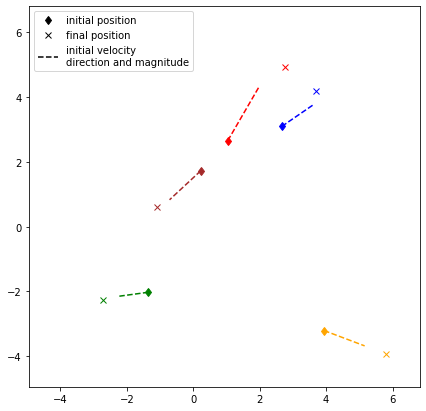

In [7]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [8]:
import torch

X_train = torch.cat((torch.tensor(positions_train[:,0,:,:]), torch.tensor(charges_train).squeeze(-1).unsqueeze(1)), dim=1)
X_train = torch.cat((X_train, torch.tensor(velocities_train).squeeze(1)), dim=1) # shape: (simulation id, parameters (x, y, c, v_x, v_y), particle id)
y_train = torch.tensor(positions_train[:,1:,:,:]) # shape: (simulation id, time (0.5, 1, 1.5), (x, y), particle id)

X_valid = torch.cat((torch.tensor(positions_valid[:,0,:,:]), torch.tensor(charges_valid).squeeze(-1).unsqueeze(1)), dim=1)
X_valid = torch.cat((X_valid, torch.tensor(velocities_valid).squeeze(1)), dim=1)
y_valid = torch.tensor(positions_valid[:,1:,:,:])

X_test = torch.cat((torch.tensor(positions_test[:,0,:,:]), torch.tensor(charges_test).squeeze(-1).unsqueeze(1)), dim=1)
X_test = torch.cat((X_test, torch.tensor(velocities_test).squeeze(1)), dim=1)
y_test = torch.tensor(positions_test[:,1:,:,:])

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64

X_subsample_100, _, y_subsample_100, _ = train_test_split(X_train, y_train, train_size=100)
X_subsample_1000, _, y_subsample_1000, _ = train_test_split(X_train, y_train, train_size=1000)
X_subsample_5000, _, y_subsample_5000, _ = train_test_split(X_train, y_train, train_size=5000)
X_subsample_10000, y_subsample_10000 = X_train, y_train

train_dataset_100 = TensorDataset(X_subsample_100, y_subsample_100)
train_dataset_1000 = TensorDataset(X_subsample_1000, y_subsample_1000)
train_dataset_5000 = TensorDataset(X_subsample_5000, y_subsample_5000)
train_dataset_10000 = TensorDataset(X_subsample_10000, y_subsample_10000)

valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train100_dataloader = DataLoader(train_dataset_100, batch_size=batch_size, shuffle=True)
train1000_dataloader = DataLoader(train_dataset_1000, batch_size=batch_size, shuffle=True)
train5000_dataloader = DataLoader(train_dataset_5000, batch_size=batch_size, shuffle=True)
train10000_dataloader = DataLoader(train_dataset_10000, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Implementation

In [17]:
import torch
import torch.nn as nn

class MessageParsing(nn.Module):
    def __init__(self, set_size: int = 5, node_shape: int = 5, edge_shape: int = 1,
                 fau_output: int = 16, output_shape: int = 32,
                 device = torch.device('cpu')):
        super(MessageParsing, self).__init__()
        
        self.fau = nn.Sequential(nn.Linear(node_shape*2 + edge_shape, fau_output),
                                            nn.LeakyReLU())
        
        self.gamma = nn.Sequential(nn.Linear(fau_output + node_shape, output_shape),
                                   nn.LeakyReLU())
        
        self.fau_output = fau_output
        self.gamma_output = output_shape
        self.device = device
        
    def forward(self, x, edges):
        """
            x - input matrix of node features (batch_size, num_nodes, num_features)
            edge - input matrix of edge information (batch_size, num_nodes, num_nodes, num_features)
        """
        embeddings = torch.zeros((x.shape[0], x.shape[1], self.gamma_output)).to(self.device)
        
        for node in range(x.shape[1]):    
            temp = torch.cat([x[:,node,:].view(x.shape[0], 1, -1).repeat((1, x.shape[1] - 1, 1)),
                              x[:, list(set(range(x.shape[1])).difference({node})), :],
                              edges[:, node, list(set(range(x.shape[1])).difference({node})), :].view(x.shape[0], 
                                                                                                      x.shape[1]-1,
                                                                                                      -1)],
                            dim = -1)
            new = self.fau(temp)

            # aggregation function over dimension = 1 -- the whole neighborhood
            #new = new.mean(axis = 1)
            new = new.max(axis = 1).values
            
            new = torch.cat([x[:,node,:].view(x.shape[0], 1, -1),
                           new.view(x.shape[0], 1, -1)],
                           dim = 2)
            
            embeddings[:,node] = self.gamma(new).view(x.shape[0], -1)
        return embeddings

class ParticleModel(nn.Module):
    def __init__(self, input_shape: int = 5, set_size: int = 5, device = torch.device('cpu')):
        super(ParticleModel, self).__init__()
        self.iteration1 = MessageParsing(output_shape = 32, device=device)
        #self.iteration2 = MessageParsing(node_shape = 32, output_shape = 16, device = device)
        self.linear = nn.Sequential(nn.Linear(32, 2))
        self.device = device
           
    def forward(self, data):
        edges = torch.stack([torch.cdist(x_i[:,:2], x_i[:,:2]) for x_i in data.swapaxes(1,2)], dim=0)\
                .view((data.shape[0], data.shape[1], data.shape[1], -1)).to(self.device)
        emb1 = self.iteration1(data.swapaxes(1,2), edges)
        #emb2 = self.iteration2(emb1, edges)
        out = self.linear(emb1)
        
        return out.swapaxes(1,2)

# Model Training

In [11]:
from tqdm import tqdm

class ParticleDistanceLoss(nn.Module):
    """
      The loss to calculate mean distance between predicted location of particle of each set.
      By defaul, Euclidean distance is set
    """

    def __init__(self, norm: float = 2):
        super(ParticleDistanceLoss, self).__init__()
        self.norm = norm

    def forward(self, input_set, target_set):
        """
            (batch_size, coordinates, set_size)
        """
        return (input_set - target_set).norm(p = self.norm, dim = 1).sum(axis = 1).mean()
        
        

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self, target_time):

        epoch_train_losses = []
        epoch_val_losses = []

        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}
        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y in self.training_DataLoader:

                A, B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                out = self.model(A)  # one forward pass

                loss += self.criterion(out, B[:,time_to_ind[target_time]])  # calculate loss
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x,  y in self.validation_DataLoader:

                A,B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    loss = 0
                    
                    out = self.model(A)  # one forward pass
                    loss += self.criterion(out, B[:,time_to_ind[target_time]])  # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate_test(self, target_time):

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss = []
            length = 0
            for x,y in self.testing_DataLoader:
                
                A, B = x.float().to(self.device), y.float().to(self.device)
                out = self.model(A)
                loss.append(self.criterion(out, B[:,time_to_ind[target_time]]))
        print(f'Test Error: {np.mean(loss):.4f} for target time {target_time}',end=' ')
        return np.mean(loss)
        
    def evaluate_train(self, target_time):

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss = []
            length = 0
            for x,y in self.training_DataLoader:
                
                A, B = x.float().to(self.device), y.float().to(self.device)
                out = self.model(A)
                loss.append(self.criterion(out, B[:,time_to_ind[target_time]]))
        print(f'Training Error: {np.mean(loss):.4f} for target time {target_time}',end=' ')
        return np.mean(loss)

## Experiments

Using full training data

#### The mean aggregation of the node neighbourhood

In [15]:
import pandas as pd

results = pd.DataFrame()

In [16]:
times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}

for train_dataloader, size in zip([train10000_dataloader, train5000_dataloader, train1000_dataloader, train100_dataloader],
                                    [10000, 5000, 1000, 100]):
    for time in times:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device=torch.device('cpu')

        model = ParticleModel(device = device).to(device)
        criterion = ParticleDistanceLoss(norm=2)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        TrainingProcedure = Trainer(model, 
                                    device, 
                                    criterion, 
                                    optimizer,
                                    train_dataloader,
                                    valid_dataloader,
                                    test_dataloader,
                                    epochs = 20)

        train_loss, val_loss = TrainingProcedure.run_trainer(target_time=time)
        test_loss = TrainingProcedure.evaluate_test(target_time=time)
        train2_loss = TrainingProcedure.evaluate_train(target_time=time)
        results = results.append({'train size': size, 'time': time,
                                  'train_loss': train_loss[-1],
                                  'val_loss': val_loss[-1],
                                  'test_loss': test_loss,
                                  'train_eval': train2_loss,
                                  'agg': 'mean'},
                                 ignore_index = True)

  5%|████▏                                                                              | 1/20 [00:02<00:48,  2.56s/it]

EPOCH: 01/20 LOSS: 2.0050 VAL-LOSS: 0.6699


 10%|████████▎                                                                          | 2/20 [00:05<00:45,  2.55s/it]

EPOCH: 02/20 LOSS: 0.7817 VAL-LOSS: 0.9971


 15%|████████████▍                                                                      | 3/20 [00:07<00:42,  2.52s/it]

EPOCH: 03/20 LOSS: 0.6561 VAL-LOSS: 0.5826


 20%|████████████████▌                                                                  | 4/20 [00:09<00:39,  2.46s/it]

EPOCH: 04/20 LOSS: 0.6051 VAL-LOSS: 0.7670


 25%|████████████████████▊                                                              | 5/20 [00:12<00:37,  2.48s/it]

EPOCH: 05/20 LOSS: 0.5927 VAL-LOSS: 0.5643


 30%|████████████████████████▉                                                          | 6/20 [00:15<00:34,  2.50s/it]

EPOCH: 06/20 LOSS: 0.5876 VAL-LOSS: 0.7055


 35%|█████████████████████████████                                                      | 7/20 [00:17<00:32,  2.52s/it]

EPOCH: 07/20 LOSS: 0.5754 VAL-LOSS: 0.5249


 40%|█████████████████████████████████▏                                                 | 8/20 [00:19<00:29,  2.47s/it]

EPOCH: 08/20 LOSS: 0.5241 VAL-LOSS: 0.5166


 45%|█████████████████████████████████████▎                                             | 9/20 [00:22<00:27,  2.46s/it]

EPOCH: 09/20 LOSS: 0.5406 VAL-LOSS: 0.5542


 50%|█████████████████████████████████████████                                         | 10/20 [00:24<00:24,  2.50s/it]

EPOCH: 10/20 LOSS: 0.5176 VAL-LOSS: 0.6151


 55%|█████████████████████████████████████████████                                     | 11/20 [00:27<00:23,  2.58s/it]

EPOCH: 11/20 LOSS: 0.5245 VAL-LOSS: 0.4977


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:30<00:20,  2.56s/it]

EPOCH: 12/20 LOSS: 0.4980 VAL-LOSS: 0.4782


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:32<00:17,  2.54s/it]

EPOCH: 13/20 LOSS: 0.4975 VAL-LOSS: 0.4406


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:35<00:14,  2.49s/it]

EPOCH: 14/20 LOSS: 0.4923 VAL-LOSS: 0.4889


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:37<00:12,  2.48s/it]

EPOCH: 15/20 LOSS: 0.5126 VAL-LOSS: 0.4745


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:40<00:09,  2.48s/it]

EPOCH: 16/20 LOSS: 0.4914 VAL-LOSS: 0.4771


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:42<00:07,  2.49s/it]

EPOCH: 17/20 LOSS: 0.4844 VAL-LOSS: 0.4758


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:45<00:04,  2.48s/it]

EPOCH: 18/20 LOSS: 0.4797 VAL-LOSS: 0.4310


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:47<00:02,  2.47s/it]

EPOCH: 19/20 LOSS: 0.4849 VAL-LOSS: 0.4355


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:50<00:00,  2.50s/it]

EPOCH: 20/20 LOSS: 0.4691 VAL-LOSS: 0.5030


Test Error: 0.5092 for target time 0.5 Training Error: 0.5122 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:02<00:47,  2.50s/it]

EPOCH: 01/20 LOSS: 2.8754 VAL-LOSS: 1.5650


 10%|████████▎                                                                          | 2/20 [00:05<00:45,  2.51s/it]

EPOCH: 02/20 LOSS: 1.4094 VAL-LOSS: 1.3409


 15%|████████████▍                                                                      | 3/20 [00:07<00:43,  2.55s/it]

EPOCH: 03/20 LOSS: 1.1480 VAL-LOSS: 1.1296


 20%|████████████████▌                                                                  | 4/20 [00:09<00:39,  2.48s/it]

EPOCH: 04/20 LOSS: 1.0482 VAL-LOSS: 1.0225


 25%|████████████████████▊                                                              | 5/20 [00:12<00:37,  2.47s/it]

EPOCH: 05/20 LOSS: 1.0365 VAL-LOSS: 1.0309


 30%|████████████████████████▉                                                          | 6/20 [00:15<00:35,  2.52s/it]

EPOCH: 06/20 LOSS: 1.0402 VAL-LOSS: 0.9728


 35%|█████████████████████████████                                                      | 7/20 [00:17<00:32,  2.47s/it]

EPOCH: 07/20 LOSS: 1.0234 VAL-LOSS: 0.9576


 40%|█████████████████████████████████▏                                                 | 8/20 [00:20<00:30,  2.51s/it]

EPOCH: 08/20 LOSS: 1.0224 VAL-LOSS: 0.9634


 45%|█████████████████████████████████████▎                                             | 9/20 [00:22<00:27,  2.49s/it]

EPOCH: 09/20 LOSS: 0.9786 VAL-LOSS: 0.9492


 50%|█████████████████████████████████████████                                         | 10/20 [00:24<00:24,  2.46s/it]

EPOCH: 10/20 LOSS: 0.9977 VAL-LOSS: 1.0125


 55%|█████████████████████████████████████████████                                     | 11/20 [00:27<00:22,  2.45s/it]

EPOCH: 11/20 LOSS: 1.0052 VAL-LOSS: 0.9849


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:29<00:19,  2.45s/it]

EPOCH: 12/20 LOSS: 0.9786 VAL-LOSS: 0.9815


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:32<00:17,  2.47s/it]

EPOCH: 13/20 LOSS: 0.9966 VAL-LOSS: 1.0498


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:34<00:14,  2.47s/it]

EPOCH: 14/20 LOSS: 0.9913 VAL-LOSS: 0.9719


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:37<00:12,  2.46s/it]

EPOCH: 15/20 LOSS: 0.9827 VAL-LOSS: 0.9417


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:39<00:09,  2.45s/it]

EPOCH: 16/20 LOSS: 0.9776 VAL-LOSS: 0.9843


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:42<00:07,  2.45s/it]

EPOCH: 17/20 LOSS: 0.9560 VAL-LOSS: 0.9099


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:44<00:04,  2.46s/it]

EPOCH: 18/20 LOSS: 0.9511 VAL-LOSS: 0.9054


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:46<00:02,  2.44s/it]

EPOCH: 19/20 LOSS: 0.9573 VAL-LOSS: 0.9302


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.46s/it]

EPOCH: 20/20 LOSS: 0.9638 VAL-LOSS: 0.9544


Test Error: 0.9818 for target time 1 Training Error: 0.9750 for target time 1 

  5%|████▏                                                                              | 1/20 [00:02<00:46,  2.46s/it]

EPOCH: 01/20 LOSS: 3.8898 VAL-LOSS: 2.4149


 10%|████████▎                                                                          | 2/20 [00:05<00:46,  2.58s/it]

EPOCH: 02/20 LOSS: 2.0075 VAL-LOSS: 2.4168


 15%|████████████▍                                                                      | 3/20 [00:07<00:43,  2.58s/it]

EPOCH: 03/20 LOSS: 1.7411 VAL-LOSS: 1.7619


 20%|████████████████▌                                                                  | 4/20 [00:10<00:41,  2.62s/it]

EPOCH: 04/20 LOSS: 1.6333 VAL-LOSS: 1.6057


 25%|████████████████████▊                                                              | 5/20 [00:12<00:38,  2.55s/it]

EPOCH: 05/20 LOSS: 1.5758 VAL-LOSS: 1.5508


 30%|████████████████████████▉                                                          | 6/20 [00:15<00:35,  2.53s/it]

EPOCH: 06/20 LOSS: 1.5508 VAL-LOSS: 1.5034


 35%|█████████████████████████████                                                      | 7/20 [00:17<00:32,  2.49s/it]

EPOCH: 07/20 LOSS: 1.5287 VAL-LOSS: 1.4528


 40%|█████████████████████████████████▏                                                 | 8/20 [00:20<00:29,  2.45s/it]

EPOCH: 08/20 LOSS: 1.5165 VAL-LOSS: 1.5126


 45%|█████████████████████████████████████▎                                             | 9/20 [00:22<00:26,  2.44s/it]

EPOCH: 09/20 LOSS: 1.5389 VAL-LOSS: 1.4922


 50%|█████████████████████████████████████████                                         | 10/20 [00:24<00:24,  2.44s/it]

EPOCH: 10/20 LOSS: 1.4915 VAL-LOSS: 1.4669


 55%|█████████████████████████████████████████████                                     | 11/20 [00:27<00:21,  2.44s/it]

EPOCH: 11/20 LOSS: 1.4930 VAL-LOSS: 1.4387


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:29<00:19,  2.43s/it]

EPOCH: 12/20 LOSS: 1.5029 VAL-LOSS: 1.4868


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:32<00:17,  2.44s/it]

EPOCH: 13/20 LOSS: 1.4899 VAL-LOSS: 1.4241


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:34<00:14,  2.43s/it]

EPOCH: 14/20 LOSS: 1.4890 VAL-LOSS: 1.5224


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:37<00:12,  2.44s/it]

EPOCH: 15/20 LOSS: 1.4990 VAL-LOSS: 1.4703


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:39<00:09,  2.43s/it]

EPOCH: 16/20 LOSS: 1.4757 VAL-LOSS: 1.4262


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:41<00:07,  2.44s/it]

EPOCH: 17/20 LOSS: 1.4944 VAL-LOSS: 1.4590


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:44<00:05,  2.50s/it]

EPOCH: 18/20 LOSS: 1.4629 VAL-LOSS: 1.4841


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:47<00:02,  2.50s/it]

EPOCH: 19/20 LOSS: 1.4752 VAL-LOSS: 1.4555


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.48s/it]

EPOCH: 20/20 LOSS: 1.4680 VAL-LOSS: 1.5073


Test Error: 1.5314 for target time 1.5 Training Error: 1.5270 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:01<00:26,  1.40s/it]

EPOCH: 01/20 LOSS: 3.3283 VAL-LOSS: 1.1738


 10%|████████▎                                                                          | 2/20 [00:02<00:25,  1.41s/it]

EPOCH: 02/20 LOSS: 1.0064 VAL-LOSS: 0.8640


 15%|████████████▍                                                                      | 3/20 [00:04<00:23,  1.36s/it]

EPOCH: 03/20 LOSS: 0.7838 VAL-LOSS: 0.7574


 20%|████████████████▌                                                                  | 4/20 [00:05<00:24,  1.50s/it]

EPOCH: 04/20 LOSS: 0.7177 VAL-LOSS: 0.6070


 25%|████████████████████▊                                                              | 5/20 [00:07<00:21,  1.43s/it]

EPOCH: 05/20 LOSS: 0.6715 VAL-LOSS: 0.7450


 30%|████████████████████████▉                                                          | 6/20 [00:08<00:19,  1.39s/it]

EPOCH: 06/20 LOSS: 0.6166 VAL-LOSS: 0.6004


 35%|█████████████████████████████                                                      | 7/20 [00:10<00:18,  1.44s/it]

EPOCH: 07/20 LOSS: 0.5889 VAL-LOSS: 0.5315


 40%|█████████████████████████████████▏                                                 | 8/20 [00:11<00:18,  1.51s/it]

EPOCH: 08/20 LOSS: 0.5838 VAL-LOSS: 0.5511


 45%|█████████████████████████████████████▎                                             | 9/20 [00:13<00:16,  1.50s/it]

EPOCH: 09/20 LOSS: 0.5577 VAL-LOSS: 0.5379


 50%|█████████████████████████████████████████                                         | 10/20 [00:14<00:15,  1.51s/it]

EPOCH: 10/20 LOSS: 0.5552 VAL-LOSS: 0.5174


 55%|█████████████████████████████████████████████                                     | 11/20 [00:16<00:13,  1.50s/it]

EPOCH: 11/20 LOSS: 0.5620 VAL-LOSS: 0.5326


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:17<00:12,  1.52s/it]

EPOCH: 12/20 LOSS: 0.5672 VAL-LOSS: 0.6149


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:19<00:10,  1.51s/it]

EPOCH: 13/20 LOSS: 0.5555 VAL-LOSS: 0.4990


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:20<00:08,  1.47s/it]

EPOCH: 14/20 LOSS: 0.5224 VAL-LOSS: 0.5333


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:22<00:07,  1.47s/it]

EPOCH: 15/20 LOSS: 0.5360 VAL-LOSS: 0.5557


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:23<00:05,  1.47s/it]

EPOCH: 16/20 LOSS: 0.5460 VAL-LOSS: 0.5627


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:25<00:04,  1.50s/it]

EPOCH: 17/20 LOSS: 0.5388 VAL-LOSS: 0.5182


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:26<00:02,  1.47s/it]

EPOCH: 18/20 LOSS: 0.5285 VAL-LOSS: 0.5213


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:27<00:01,  1.44s/it]

EPOCH: 19/20 LOSS: 0.5194 VAL-LOSS: 0.4724


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.46s/it]

EPOCH: 20/20 LOSS: 0.5256 VAL-LOSS: 0.5918


Test Error: 0.6012 for target time 0.5 Training Error: 0.6015 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:01<00:25,  1.36s/it]

EPOCH: 01/20 LOSS: 3.9374 VAL-LOSS: 1.9863


 10%|████████▎                                                                          | 2/20 [00:02<00:24,  1.38s/it]

EPOCH: 02/20 LOSS: 1.7786 VAL-LOSS: 1.6775


 15%|████████████▍                                                                      | 3/20 [00:04<00:23,  1.41s/it]

EPOCH: 03/20 LOSS: 1.6109 VAL-LOSS: 1.4213


 20%|████████████████▌                                                                  | 4/20 [00:05<00:21,  1.34s/it]

EPOCH: 04/20 LOSS: 1.3113 VAL-LOSS: 1.4262


 25%|████████████████████▊                                                              | 5/20 [00:06<00:20,  1.36s/it]

EPOCH: 05/20 LOSS: 1.2041 VAL-LOSS: 1.0926


 30%|████████████████████████▉                                                          | 6/20 [00:08<00:18,  1.35s/it]

EPOCH: 06/20 LOSS: 1.0921 VAL-LOSS: 1.0485


 35%|█████████████████████████████                                                      | 7/20 [00:09<00:17,  1.34s/it]

EPOCH: 07/20 LOSS: 1.0769 VAL-LOSS: 1.0959


 40%|█████████████████████████████████▏                                                 | 8/20 [00:10<00:16,  1.35s/it]

EPOCH: 08/20 LOSS: 1.0667 VAL-LOSS: 1.0534


 45%|█████████████████████████████████████▎                                             | 9/20 [00:12<00:14,  1.36s/it]

EPOCH: 09/20 LOSS: 1.0325 VAL-LOSS: 0.9752


 50%|█████████████████████████████████████████                                         | 10/20 [00:13<00:13,  1.36s/it]

EPOCH: 10/20 LOSS: 1.0230 VAL-LOSS: 1.0181


 55%|█████████████████████████████████████████████                                     | 11/20 [00:14<00:12,  1.36s/it]

EPOCH: 11/20 LOSS: 1.0315 VAL-LOSS: 1.0494


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:16<00:11,  1.38s/it]

EPOCH: 12/20 LOSS: 1.0279 VAL-LOSS: 0.9548


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:17<00:09,  1.40s/it]

EPOCH: 13/20 LOSS: 0.9989 VAL-LOSS: 1.0742


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:19<00:08,  1.40s/it]

EPOCH: 14/20 LOSS: 1.0055 VAL-LOSS: 0.9963


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:20<00:06,  1.39s/it]

EPOCH: 15/20 LOSS: 1.0015 VAL-LOSS: 1.0014


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:21<00:05,  1.39s/it]

EPOCH: 16/20 LOSS: 0.9877 VAL-LOSS: 0.9778


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:23<00:04,  1.38s/it]

EPOCH: 17/20 LOSS: 0.9947 VAL-LOSS: 0.9964


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:24<00:02,  1.38s/it]

EPOCH: 18/20 LOSS: 1.0084 VAL-LOSS: 0.9564


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:26<00:01,  1.38s/it]

EPOCH: 19/20 LOSS: 0.9826 VAL-LOSS: 0.9413


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

EPOCH: 20/20 LOSS: 0.9844 VAL-LOSS: 0.9643


Test Error: 0.9786 for target time 1 Training Error: 0.9789 for target time 1 

  5%|████▏                                                                              | 1/20 [00:01<00:24,  1.29s/it]

EPOCH: 01/20 LOSS: 4.9533 VAL-LOSS: 2.9425


 10%|████████▎                                                                          | 2/20 [00:02<00:23,  1.31s/it]

EPOCH: 02/20 LOSS: 2.6502 VAL-LOSS: 2.3731


 15%|████████████▍                                                                      | 3/20 [00:03<00:22,  1.32s/it]

EPOCH: 03/20 LOSS: 2.1103 VAL-LOSS: 1.9224


 20%|████████████████▌                                                                  | 4/20 [00:05<00:21,  1.32s/it]

EPOCH: 04/20 LOSS: 1.7895 VAL-LOSS: 1.7930


 25%|████████████████████▊                                                              | 5/20 [00:06<00:19,  1.33s/it]

EPOCH: 05/20 LOSS: 1.7020 VAL-LOSS: 1.6604


 30%|████████████████████████▉                                                          | 6/20 [00:07<00:18,  1.33s/it]

EPOCH: 06/20 LOSS: 1.6346 VAL-LOSS: 1.5745


 35%|█████████████████████████████                                                      | 7/20 [00:09<00:17,  1.33s/it]

EPOCH: 07/20 LOSS: 1.6278 VAL-LOSS: 1.6422


 40%|█████████████████████████████████▏                                                 | 8/20 [00:10<00:15,  1.32s/it]

EPOCH: 08/20 LOSS: 1.5422 VAL-LOSS: 1.4851


 45%|█████████████████████████████████████▎                                             | 9/20 [00:11<00:14,  1.32s/it]

EPOCH: 09/20 LOSS: 1.4976 VAL-LOSS: 1.5079


 50%|█████████████████████████████████████████                                         | 10/20 [00:13<00:13,  1.31s/it]

EPOCH: 10/20 LOSS: 1.5049 VAL-LOSS: 1.5136


 55%|█████████████████████████████████████████████                                     | 11/20 [00:14<00:11,  1.32s/it]

EPOCH: 11/20 LOSS: 1.5157 VAL-LOSS: 1.4956


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:15<00:10,  1.33s/it]

EPOCH: 12/20 LOSS: 1.5001 VAL-LOSS: 1.5129


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:17<00:09,  1.32s/it]

EPOCH: 13/20 LOSS: 1.4857 VAL-LOSS: 1.4413


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:18<00:07,  1.32s/it]

EPOCH: 14/20 LOSS: 1.4750 VAL-LOSS: 1.5005


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:19<00:06,  1.33s/it]

EPOCH: 15/20 LOSS: 1.4750 VAL-LOSS: 1.5085


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:21<00:05,  1.35s/it]

EPOCH: 16/20 LOSS: 1.4905 VAL-LOSS: 1.5045


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:22<00:04,  1.39s/it]

EPOCH: 17/20 LOSS: 1.4747 VAL-LOSS: 1.4430


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:24<00:02,  1.44s/it]

EPOCH: 18/20 LOSS: 1.4814 VAL-LOSS: 1.4670


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:25<00:01,  1.51s/it]

EPOCH: 19/20 LOSS: 1.4872 VAL-LOSS: 1.4507


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

EPOCH: 20/20 LOSS: 1.4809 VAL-LOSS: 1.4545


Test Error: 1.4708 for target time 1.5 Training Error: 1.4515 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:00<00:12,  1.56it/s]

EPOCH: 01/20 LOSS: 7.5921 VAL-LOSS: 3.1884


 10%|████████▎                                                                          | 2/20 [00:01<00:11,  1.59it/s]

EPOCH: 02/20 LOSS: 2.3719 VAL-LOSS: 1.6799


 15%|████████████▍                                                                      | 3/20 [00:01<00:10,  1.68it/s]

EPOCH: 03/20 LOSS: 1.3667 VAL-LOSS: 1.3845


 20%|████████████████▌                                                                  | 4/20 [00:02<00:09,  1.77it/s]

EPOCH: 04/20 LOSS: 1.1350 VAL-LOSS: 1.0271


 25%|████████████████████▊                                                              | 5/20 [00:02<00:08,  1.82it/s]

EPOCH: 05/20 LOSS: 1.0317 VAL-LOSS: 0.9358


 30%|████████████████████████▉                                                          | 6/20 [00:03<00:07,  1.86it/s]

EPOCH: 06/20 LOSS: 0.9736 VAL-LOSS: 0.9116


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:06,  1.89it/s]

EPOCH: 07/20 LOSS: 0.9528 VAL-LOSS: 1.1087


 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:06,  1.92it/s]

EPOCH: 08/20 LOSS: 1.0694 VAL-LOSS: 1.2933


 45%|█████████████████████████████████████▎                                             | 9/20 [00:04<00:05,  1.86it/s]

EPOCH: 09/20 LOSS: 1.0339 VAL-LOSS: 1.0232


 50%|█████████████████████████████████████████                                         | 10/20 [00:05<00:05,  1.82it/s]

EPOCH: 10/20 LOSS: 0.9081 VAL-LOSS: 0.8973


 55%|█████████████████████████████████████████████                                     | 11/20 [00:06<00:04,  1.83it/s]

EPOCH: 11/20 LOSS: 0.8862 VAL-LOSS: 0.8809


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:06<00:04,  1.81it/s]

EPOCH: 12/20 LOSS: 0.9253 VAL-LOSS: 0.8072


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:07<00:03,  1.84it/s]

EPOCH: 13/20 LOSS: 0.7753 VAL-LOSS: 0.7102


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:07<00:03,  1.74it/s]

EPOCH: 14/20 LOSS: 0.8644 VAL-LOSS: 0.7917


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:08<00:03,  1.66it/s]

EPOCH: 15/20 LOSS: 0.8147 VAL-LOSS: 0.9260


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:09<00:02,  1.73it/s]

EPOCH: 16/20 LOSS: 0.8040 VAL-LOSS: 0.7258


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:09<00:01,  1.75it/s]

EPOCH: 17/20 LOSS: 0.7449 VAL-LOSS: 0.6429


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:10<00:01,  1.81it/s]

EPOCH: 18/20 LOSS: 0.6566 VAL-LOSS: 0.6990


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:10<00:00,  1.86it/s]

EPOCH: 19/20 LOSS: 0.8990 VAL-LOSS: 0.9551


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.81it/s]

EPOCH: 20/20 LOSS: 0.7392 VAL-LOSS: 0.7180


Test Error: 0.7265 for target time 0.5 Training Error: 0.6895 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:10,  1.87it/s]

EPOCH: 01/20 LOSS: 9.9677 VAL-LOSS: 4.6761


 10%|████████▎                                                                          | 2/20 [00:01<00:09,  1.94it/s]

EPOCH: 02/20 LOSS: 3.2000 VAL-LOSS: 2.6563


 15%|████████████▍                                                                      | 3/20 [00:01<00:09,  1.84it/s]

EPOCH: 03/20 LOSS: 2.2699 VAL-LOSS: 2.1526


 20%|████████████████▌                                                                  | 4/20 [00:02<00:08,  1.87it/s]

EPOCH: 04/20 LOSS: 2.0626 VAL-LOSS: 1.9249


 25%|████████████████████▊                                                              | 5/20 [00:02<00:07,  1.92it/s]

EPOCH: 05/20 LOSS: 1.8874 VAL-LOSS: 1.8190


 30%|████████████████████████▉                                                          | 6/20 [00:03<00:07,  1.93it/s]

EPOCH: 06/20 LOSS: 1.8650 VAL-LOSS: 1.9621


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:06,  1.94it/s]

EPOCH: 07/20 LOSS: 1.8152 VAL-LOSS: 1.7634


 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:06,  1.92it/s]

EPOCH: 08/20 LOSS: 1.7124 VAL-LOSS: 1.6015


 45%|█████████████████████████████████████▎                                             | 9/20 [00:04<00:05,  1.85it/s]

EPOCH: 09/20 LOSS: 1.5310 VAL-LOSS: 1.5474


 50%|█████████████████████████████████████████                                         | 10/20 [00:05<00:05,  1.77it/s]

EPOCH: 10/20 LOSS: 1.4343 VAL-LOSS: 1.6158


 55%|█████████████████████████████████████████████                                     | 11/20 [00:05<00:04,  1.80it/s]

EPOCH: 11/20 LOSS: 1.5573 VAL-LOSS: 1.7450


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:06<00:04,  1.78it/s]

EPOCH: 12/20 LOSS: 1.4792 VAL-LOSS: 1.3686


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:07<00:03,  1.81it/s]

EPOCH: 13/20 LOSS: 1.3447 VAL-LOSS: 1.2996


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:07<00:03,  1.78it/s]

EPOCH: 14/20 LOSS: 1.2141 VAL-LOSS: 1.2623


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:08<00:02,  1.82it/s]

EPOCH: 15/20 LOSS: 1.1954 VAL-LOSS: 1.1468


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:08<00:02,  1.79it/s]

EPOCH: 16/20 LOSS: 1.1552 VAL-LOSS: 1.3156


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:09<00:01,  1.79it/s]

EPOCH: 17/20 LOSS: 1.2220 VAL-LOSS: 1.2794


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:09<00:01,  1.74it/s]

EPOCH: 18/20 LOSS: 1.1534 VAL-LOSS: 1.2909


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:10<00:00,  1.70it/s]

EPOCH: 19/20 LOSS: 1.1082 VAL-LOSS: 1.2727


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.80it/s]

EPOCH: 20/20 LOSS: 1.1671 VAL-LOSS: 1.2481


Test Error: 1.2708 for target time 1 Training Error: 1.2095 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:12,  1.58it/s]

EPOCH: 01/20 LOSS: 12.4213 VAL-LOSS: 6.4298


 10%|████████▎                                                                          | 2/20 [00:01<00:10,  1.77it/s]

EPOCH: 02/20 LOSS: 4.4938 VAL-LOSS: 3.3786


 15%|████████████▍                                                                      | 3/20 [00:01<00:09,  1.78it/s]

EPOCH: 03/20 LOSS: 3.1899 VAL-LOSS: 3.0201


 20%|████████████████▌                                                                  | 4/20 [00:02<00:09,  1.77it/s]

EPOCH: 04/20 LOSS: 2.8737 VAL-LOSS: 2.8252


 25%|████████████████████▊                                                              | 5/20 [00:02<00:08,  1.74it/s]

EPOCH: 05/20 LOSS: 2.8127 VAL-LOSS: 2.7167


 30%|████████████████████████▉                                                          | 6/20 [00:03<00:07,  1.75it/s]

EPOCH: 06/20 LOSS: 2.6172 VAL-LOSS: 2.4544


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:07,  1.82it/s]

EPOCH: 07/20 LOSS: 2.3238 VAL-LOSS: 2.2829


 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:06,  1.84it/s]

EPOCH: 08/20 LOSS: 2.2361 VAL-LOSS: 2.1804


 45%|█████████████████████████████████████▎                                             | 9/20 [00:04<00:05,  1.87it/s]

EPOCH: 09/20 LOSS: 2.0353 VAL-LOSS: 1.9882


 50%|█████████████████████████████████████████                                         | 10/20 [00:05<00:05,  1.91it/s]

EPOCH: 10/20 LOSS: 1.9541 VAL-LOSS: 2.0699


 55%|█████████████████████████████████████████████                                     | 11/20 [00:05<00:04,  1.92it/s]

EPOCH: 11/20 LOSS: 1.8063 VAL-LOSS: 1.8143


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:06<00:04,  1.95it/s]

EPOCH: 12/20 LOSS: 1.7393 VAL-LOSS: 1.7404


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:06<00:03,  1.99it/s]

EPOCH: 13/20 LOSS: 1.7555 VAL-LOSS: 1.7764


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:07<00:02,  2.02it/s]

EPOCH: 14/20 LOSS: 1.7425 VAL-LOSS: 1.6665


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:07<00:02,  2.00it/s]

EPOCH: 15/20 LOSS: 1.5869 VAL-LOSS: 1.6303


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:08<00:01,  2.00it/s]

EPOCH: 16/20 LOSS: 1.5844 VAL-LOSS: 1.6526


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:08<00:01,  2.02it/s]

EPOCH: 17/20 LOSS: 1.5804 VAL-LOSS: 1.6148


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:09<00:00,  2.03it/s]

EPOCH: 18/20 LOSS: 1.5459 VAL-LOSS: 1.6492


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:09<00:00,  1.97it/s]

EPOCH: 19/20 LOSS: 1.5433 VAL-LOSS: 1.6397


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]

EPOCH: 20/20 LOSS: 1.4954 VAL-LOSS: 1.5548


Test Error: 1.5923 for target time 1.5 Training Error: 1.4690 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:00<00:05,  3.33it/s]

EPOCH: 01/20 LOSS: 15.8241 VAL-LOSS: 15.2083


 10%|████████▎                                                                          | 2/20 [00:00<00:05,  3.28it/s]

EPOCH: 02/20 LOSS: 14.1454 VAL-LOSS: 13.5430


 15%|████████████▍                                                                      | 3/20 [00:00<00:05,  3.21it/s]

EPOCH: 03/20 LOSS: 12.5199 VAL-LOSS: 11.3048


 20%|████████████████▌                                                                  | 4/20 [00:01<00:05,  3.02it/s]

EPOCH: 04/20 LOSS: 10.1180 VAL-LOSS: 8.3530


 25%|████████████████████▊                                                              | 5/20 [00:01<00:05,  2.98it/s]

EPOCH: 05/20 LOSS: 7.2158 VAL-LOSS: 5.2459


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:04,  3.03it/s]

EPOCH: 06/20 LOSS: 4.5300 VAL-LOSS: 4.0954


 35%|█████████████████████████████                                                      | 7/20 [00:02<00:04,  3.04it/s]

EPOCH: 07/20 LOSS: 3.9449 VAL-LOSS: 4.6831


 40%|█████████████████████████████████▏                                                 | 8/20 [00:02<00:03,  3.05it/s]

EPOCH: 08/20 LOSS: 4.5511 VAL-LOSS: 4.3753


 45%|█████████████████████████████████████▎                                             | 9/20 [00:02<00:03,  3.15it/s]

EPOCH: 09/20 LOSS: 4.0001 VAL-LOSS: 3.1453


 50%|█████████████████████████████████████████                                         | 10/20 [00:03<00:03,  3.19it/s]

EPOCH: 10/20 LOSS: 2.7869 VAL-LOSS: 2.5828


 55%|█████████████████████████████████████████████                                     | 11/20 [00:03<00:02,  3.16it/s]

EPOCH: 11/20 LOSS: 2.5767 VAL-LOSS: 2.9774


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:03<00:02,  2.92it/s]

EPOCH: 12/20 LOSS: 2.7661 VAL-LOSS: 2.9926


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:04<00:02,  2.71it/s]

EPOCH: 13/20 LOSS: 2.6493 VAL-LOSS: 2.5345


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:04<00:02,  2.77it/s]

EPOCH: 14/20 LOSS: 2.2007 VAL-LOSS: 1.9019


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:05<00:01,  2.84it/s]

EPOCH: 15/20 LOSS: 1.8733 VAL-LOSS: 2.0317


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:05<00:01,  2.90it/s]

EPOCH: 16/20 LOSS: 1.9976 VAL-LOSS: 1.9226


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:05<00:01,  2.99it/s]

EPOCH: 17/20 LOSS: 1.8331 VAL-LOSS: 1.5620


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:06<00:00,  2.70it/s]

EPOCH: 18/20 LOSS: 1.5304 VAL-LOSS: 1.6933


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:06<00:00,  2.83it/s]

EPOCH: 19/20 LOSS: 1.6259 VAL-LOSS: 1.6549


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]

EPOCH: 20/20 LOSS: 1.5195 VAL-LOSS: 1.4476


Test Error: 1.4602 for target time 0.5 Training Error: 1.3806 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:06,  3.08it/s]

EPOCH: 01/20 LOSS: 17.3017 VAL-LOSS: 15.7652


 10%|████████▎                                                                          | 2/20 [00:00<00:05,  3.17it/s]

EPOCH: 02/20 LOSS: 14.4497 VAL-LOSS: 12.6484


 15%|████████████▍                                                                      | 3/20 [00:00<00:05,  3.12it/s]

EPOCH: 03/20 LOSS: 11.2625 VAL-LOSS: 9.3021


 20%|████████████████▌                                                                  | 4/20 [00:01<00:05,  2.91it/s]

EPOCH: 04/20 LOSS: 8.0445 VAL-LOSS: 6.6448


 25%|████████████████████▊                                                              | 5/20 [00:01<00:05,  2.95it/s]

EPOCH: 05/20 LOSS: 5.9915 VAL-LOSS: 5.4690


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:04,  3.04it/s]

EPOCH: 06/20 LOSS: 5.2073 VAL-LOSS: 5.1179


 35%|█████████████████████████████                                                      | 7/20 [00:02<00:04,  3.11it/s]

EPOCH: 07/20 LOSS: 5.0772 VAL-LOSS: 5.1592


 40%|█████████████████████████████████▏                                                 | 8/20 [00:02<00:03,  3.18it/s]

EPOCH: 08/20 LOSS: 4.8968 VAL-LOSS: 4.4531


 45%|█████████████████████████████████████▎                                             | 9/20 [00:02<00:03,  3.18it/s]

EPOCH: 09/20 LOSS: 4.1478 VAL-LOSS: 3.9966


 50%|█████████████████████████████████████████                                         | 10/20 [00:03<00:03,  3.13it/s]

EPOCH: 10/20 LOSS: 3.7338 VAL-LOSS: 3.8281


 55%|█████████████████████████████████████████████                                     | 11/20 [00:03<00:02,  3.00it/s]

EPOCH: 11/20 LOSS: 3.5991 VAL-LOSS: 3.7406


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:03<00:02,  2.98it/s]

EPOCH: 12/20 LOSS: 3.4915 VAL-LOSS: 3.5963


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:04<00:02,  2.93it/s]

EPOCH: 13/20 LOSS: 3.3473 VAL-LOSS: 3.1623


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:04<00:02,  2.97it/s]

EPOCH: 14/20 LOSS: 2.9899 VAL-LOSS: 2.8816


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:05<00:01,  2.59it/s]

EPOCH: 15/20 LOSS: 2.7774 VAL-LOSS: 2.9034


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:05<00:01,  2.72it/s]

EPOCH: 16/20 LOSS: 2.8915 VAL-LOSS: 2.9165


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:05<00:01,  2.75it/s]

EPOCH: 17/20 LOSS: 2.7911 VAL-LOSS: 2.7191


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:06<00:00,  2.67it/s]

EPOCH: 18/20 LOSS: 2.5602 VAL-LOSS: 2.5613


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:06<00:00,  2.78it/s]

EPOCH: 19/20 LOSS: 2.4612 VAL-LOSS: 2.6463


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]

EPOCH: 20/20 LOSS: 2.5551 VAL-LOSS: 2.4601


Test Error: 2.4434 for target time 1 Training Error: 2.3422 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:06,  2.85it/s]

EPOCH: 01/20 LOSS: 19.5554 VAL-LOSS: 18.3444


 10%|████████▎                                                                          | 2/20 [00:00<00:09,  1.98it/s]

EPOCH: 02/20 LOSS: 17.0755 VAL-LOSS: 16.1554


 15%|████████████▍                                                                      | 3/20 [00:01<00:08,  2.03it/s]

EPOCH: 03/20 LOSS: 14.9037 VAL-LOSS: 13.3774


 20%|████████████████▌                                                                  | 4/20 [00:01<00:07,  2.13it/s]

EPOCH: 04/20 LOSS: 12.2452 VAL-LOSS: 9.9560


 25%|████████████████████▊                                                              | 5/20 [00:02<00:06,  2.32it/s]

EPOCH: 05/20 LOSS: 8.6250 VAL-LOSS: 6.5690


 30%|████████████████████████▉                                                          | 6/20 [00:02<00:05,  2.51it/s]

EPOCH: 06/20 LOSS: 5.6317 VAL-LOSS: 5.7211


 35%|█████████████████████████████                                                      | 7/20 [00:02<00:04,  2.65it/s]

EPOCH: 07/20 LOSS: 5.8386 VAL-LOSS: 6.8497


 40%|█████████████████████████████████▏                                                 | 8/20 [00:03<00:04,  2.71it/s]

EPOCH: 08/20 LOSS: 6.7431 VAL-LOSS: 6.3760


 45%|█████████████████████████████████████▎                                             | 9/20 [00:03<00:03,  2.79it/s]

EPOCH: 09/20 LOSS: 5.7928 VAL-LOSS: 4.8827


 50%|█████████████████████████████████████████                                         | 10/20 [00:03<00:03,  2.90it/s]

EPOCH: 10/20 LOSS: 4.6317 VAL-LOSS: 4.4535


 55%|█████████████████████████████████████████████                                     | 11/20 [00:04<00:02,  3.03it/s]

EPOCH: 11/20 LOSS: 4.3648 VAL-LOSS: 4.8850


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:04<00:02,  2.87it/s]

EPOCH: 12/20 LOSS: 4.6710 VAL-LOSS: 5.1357


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:04<00:02,  2.94it/s]

EPOCH: 13/20 LOSS: 4.7212 VAL-LOSS: 4.8127


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:05<00:02,  2.96it/s]

EPOCH: 14/20 LOSS: 4.4213 VAL-LOSS: 4.1144


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:05<00:01,  2.99it/s]

EPOCH: 15/20 LOSS: 3.7805 VAL-LOSS: 3.8248


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:05<00:01,  2.94it/s]

EPOCH: 16/20 LOSS: 3.7913 VAL-LOSS: 4.0385


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:06<00:01,  2.94it/s]

EPOCH: 17/20 LOSS: 3.9937 VAL-LOSS: 3.8691


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:06<00:00,  2.90it/s]

EPOCH: 18/20 LOSS: 3.7318 VAL-LOSS: 3.5775


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:06<00:00,  2.84it/s]

EPOCH: 19/20 LOSS: 3.5774 VAL-LOSS: 3.5791


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.73it/s]

EPOCH: 20/20 LOSS: 3.4889 VAL-LOSS: 3.7167


Test Error: 3.7074 for target time 1.5 Training Error: 3.6219 for target time 1.5 

#### The max pooling aggregation of the node neighbourhood

In [18]:
results2 = pd.DataFrame()

In [19]:
times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}

for train_dataloader, size in zip([train10000_dataloader, train5000_dataloader, train1000_dataloader, train100_dataloader],
                                    [10000, 5000, 1000, 100]):
    for time in times:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device=torch.device('cpu')

        model = ParticleModel(device = device).to(device)
        criterion = ParticleDistanceLoss(norm=2)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        TrainingProcedure = Trainer(model, 
                                    device, 
                                    criterion, 
                                    optimizer,
                                    train_dataloader,
                                    valid_dataloader,
                                    test_dataloader,
                                    epochs = 20)

        train_loss, val_loss = TrainingProcedure.run_trainer(target_time=time)
        test_loss = TrainingProcedure.evaluate_test(target_time=time)
        train2_loss = TrainingProcedure.evaluate_train(target_time=time)
        results2 = results2.append({'train size': size,
                                   'time': time,
                                   'train_loss': train_loss[-1],
                                   'val_loss': val_loss[-1],
                                   'test_loss': test_loss,
                                   'train_eval': train2_loss,
                                   'agg': 'max pooling'},
                                 ignore_index = True)

  5%|████▏                                                                              | 1/20 [00:02<00:52,  2.77s/it]

EPOCH: 01/20 LOSS: 2.0051 VAL-LOSS: 1.2207


 10%|████████▎                                                                          | 2/20 [00:05<00:46,  2.59s/it]

EPOCH: 02/20 LOSS: 0.8471 VAL-LOSS: 0.7468


 15%|████████████▍                                                                      | 3/20 [00:07<00:42,  2.52s/it]

EPOCH: 03/20 LOSS: 0.7866 VAL-LOSS: 0.7258


 20%|████████████████▌                                                                  | 4/20 [00:09<00:38,  2.42s/it]

EPOCH: 04/20 LOSS: 0.6573 VAL-LOSS: 0.5472


 25%|████████████████████▊                                                              | 5/20 [00:12<00:35,  2.38s/it]

EPOCH: 05/20 LOSS: 0.6743 VAL-LOSS: 0.6431


 30%|████████████████████████▉                                                          | 6/20 [00:14<00:33,  2.38s/it]

EPOCH: 06/20 LOSS: 0.6257 VAL-LOSS: 0.6390


 35%|█████████████████████████████                                                      | 7/20 [00:17<00:31,  2.39s/it]

EPOCH: 07/20 LOSS: 0.5915 VAL-LOSS: 0.5527


 40%|█████████████████████████████████▏                                                 | 8/20 [00:19<00:28,  2.39s/it]

EPOCH: 08/20 LOSS: 0.5693 VAL-LOSS: 0.5430


 45%|█████████████████████████████████████▎                                             | 9/20 [00:21<00:26,  2.37s/it]

EPOCH: 09/20 LOSS: 0.5631 VAL-LOSS: 0.5418


 50%|█████████████████████████████████████████                                         | 10/20 [00:24<00:23,  2.38s/it]

EPOCH: 10/20 LOSS: 0.5311 VAL-LOSS: 0.4744


 55%|█████████████████████████████████████████████                                     | 11/20 [00:26<00:21,  2.36s/it]

EPOCH: 11/20 LOSS: 0.5107 VAL-LOSS: 0.6094


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:28<00:18,  2.34s/it]

EPOCH: 12/20 LOSS: 0.5129 VAL-LOSS: 0.4734


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:31<00:16,  2.34s/it]

EPOCH: 13/20 LOSS: 0.5245 VAL-LOSS: 0.4785


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:33<00:14,  2.34s/it]

EPOCH: 14/20 LOSS: 0.5040 VAL-LOSS: 0.4757


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:35<00:11,  2.34s/it]

EPOCH: 15/20 LOSS: 0.5044 VAL-LOSS: 0.5116


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:38<00:09,  2.35s/it]

EPOCH: 16/20 LOSS: 0.5016 VAL-LOSS: 0.4505


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:40<00:07,  2.37s/it]

EPOCH: 17/20 LOSS: 0.5064 VAL-LOSS: 0.5019


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:43<00:04,  2.39s/it]

EPOCH: 18/20 LOSS: 0.5051 VAL-LOSS: 0.4796


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:45<00:02,  2.36s/it]

EPOCH: 19/20 LOSS: 0.5000 VAL-LOSS: 0.5037


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.38s/it]

EPOCH: 20/20 LOSS: 0.4953 VAL-LOSS: 0.4608


Test Error: 0.4690 for target time 0.5 Training Error: 0.4712 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:02<00:44,  2.34s/it]

EPOCH: 01/20 LOSS: 3.0754 VAL-LOSS: 1.7609


 10%|████████▎                                                                          | 2/20 [00:04<00:42,  2.35s/it]

EPOCH: 02/20 LOSS: 1.3634 VAL-LOSS: 1.1563


 15%|████████████▍                                                                      | 3/20 [00:06<00:39,  2.32s/it]

EPOCH: 03/20 LOSS: 1.1585 VAL-LOSS: 1.0417


 20%|████████████████▌                                                                  | 4/20 [00:09<00:37,  2.32s/it]

EPOCH: 04/20 LOSS: 1.0651 VAL-LOSS: 0.9829


 25%|████████████████████▊                                                              | 5/20 [00:11<00:35,  2.36s/it]

EPOCH: 05/20 LOSS: 1.0080 VAL-LOSS: 0.9526


 30%|████████████████████████▉                                                          | 6/20 [00:14<00:32,  2.34s/it]

EPOCH: 06/20 LOSS: 0.9841 VAL-LOSS: 0.9824


 35%|█████████████████████████████                                                      | 7/20 [00:16<00:30,  2.32s/it]

EPOCH: 07/20 LOSS: 0.9732 VAL-LOSS: 0.9418


 40%|█████████████████████████████████▏                                                 | 8/20 [00:18<00:27,  2.31s/it]

EPOCH: 08/20 LOSS: 0.9772 VAL-LOSS: 0.9991


 45%|█████████████████████████████████████▎                                             | 9/20 [00:20<00:25,  2.32s/it]

EPOCH: 09/20 LOSS: 0.9690 VAL-LOSS: 0.9566


 50%|█████████████████████████████████████████                                         | 10/20 [00:23<00:23,  2.32s/it]

EPOCH: 10/20 LOSS: 0.9601 VAL-LOSS: 0.9530


 55%|█████████████████████████████████████████████                                     | 11/20 [00:25<00:20,  2.33s/it]

EPOCH: 11/20 LOSS: 0.9534 VAL-LOSS: 0.9543


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:27<00:18,  2.32s/it]

EPOCH: 12/20 LOSS: 0.9609 VAL-LOSS: 0.9208


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:30<00:16,  2.32s/it]

EPOCH: 13/20 LOSS: 0.9502 VAL-LOSS: 0.9534


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:32<00:13,  2.32s/it]

EPOCH: 14/20 LOSS: 0.9476 VAL-LOSS: 0.8918


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:34<00:11,  2.32s/it]

EPOCH: 15/20 LOSS: 0.9483 VAL-LOSS: 0.9018


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:37<00:09,  2.32s/it]

EPOCH: 16/20 LOSS: 0.9417 VAL-LOSS: 0.9635


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:39<00:06,  2.32s/it]

EPOCH: 17/20 LOSS: 0.9444 VAL-LOSS: 0.8837


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:41<00:04,  2.29s/it]

EPOCH: 18/20 LOSS: 0.9219 VAL-LOSS: 0.8994


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:44<00:02,  2.33s/it]

EPOCH: 19/20 LOSS: 0.9333 VAL-LOSS: 0.9231


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.32s/it]

EPOCH: 20/20 LOSS: 0.9316 VAL-LOSS: 0.9143


Test Error: 0.9398 for target time 1 Training Error: 0.9369 for target time 1 

  5%|████▏                                                                              | 1/20 [00:02<00:45,  2.37s/it]

EPOCH: 01/20 LOSS: 3.9173 VAL-LOSS: 2.4938


 10%|████████▎                                                                          | 2/20 [00:04<00:44,  2.45s/it]

EPOCH: 02/20 LOSS: 2.1067 VAL-LOSS: 1.7752


 15%|████████████▍                                                                      | 3/20 [00:07<00:40,  2.40s/it]

EPOCH: 03/20 LOSS: 1.7113 VAL-LOSS: 1.6220


 20%|████████████████▌                                                                  | 4/20 [00:09<00:38,  2.39s/it]

EPOCH: 04/20 LOSS: 1.5933 VAL-LOSS: 1.4919


 25%|████████████████████▊                                                              | 5/20 [00:11<00:35,  2.39s/it]

EPOCH: 05/20 LOSS: 1.5478 VAL-LOSS: 1.5002


 30%|████████████████████████▉                                                          | 6/20 [00:14<00:33,  2.37s/it]

EPOCH: 06/20 LOSS: 1.5176 VAL-LOSS: 1.4595


 35%|█████████████████████████████                                                      | 7/20 [00:16<00:30,  2.38s/it]

EPOCH: 07/20 LOSS: 1.5201 VAL-LOSS: 1.4794


 40%|█████████████████████████████████▏                                                 | 8/20 [00:19<00:28,  2.37s/it]

EPOCH: 08/20 LOSS: 1.5046 VAL-LOSS: 1.5628


 45%|█████████████████████████████████████▎                                             | 9/20 [00:21<00:26,  2.37s/it]

EPOCH: 09/20 LOSS: 1.4904 VAL-LOSS: 1.4859


 50%|█████████████████████████████████████████                                         | 10/20 [00:23<00:23,  2.35s/it]

EPOCH: 10/20 LOSS: 1.4831 VAL-LOSS: 1.4679


 55%|█████████████████████████████████████████████                                     | 11/20 [00:26<00:21,  2.35s/it]

EPOCH: 11/20 LOSS: 1.4794 VAL-LOSS: 1.4589


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:28<00:18,  2.36s/it]

EPOCH: 12/20 LOSS: 1.4852 VAL-LOSS: 1.4527


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:30<00:16,  2.33s/it]

EPOCH: 13/20 LOSS: 1.4892 VAL-LOSS: 1.4511


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:33<00:13,  2.33s/it]

EPOCH: 14/20 LOSS: 1.4717 VAL-LOSS: 1.4560


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:35<00:11,  2.33s/it]

EPOCH: 15/20 LOSS: 1.4732 VAL-LOSS: 1.4437


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:37<00:09,  2.33s/it]

EPOCH: 16/20 LOSS: 1.4524 VAL-LOSS: 1.4349


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:40<00:06,  2.32s/it]

EPOCH: 17/20 LOSS: 1.4618 VAL-LOSS: 1.4674


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:42<00:04,  2.31s/it]

EPOCH: 18/20 LOSS: 1.4604 VAL-LOSS: 1.4746


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:44<00:02,  2.32s/it]

EPOCH: 19/20 LOSS: 1.4584 VAL-LOSS: 1.4565


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.39s/it]

EPOCH: 20/20 LOSS: 1.4644 VAL-LOSS: 1.4942


Test Error: 1.5138 for target time 1.5 Training Error: 1.5066 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:01<00:27,  1.43s/it]

EPOCH: 01/20 LOSS: 3.0044 VAL-LOSS: 1.1869


 10%|████████▎                                                                          | 2/20 [00:02<00:25,  1.43s/it]

EPOCH: 02/20 LOSS: 0.8768 VAL-LOSS: 0.8851


 15%|████████████▍                                                                      | 3/20 [00:04<00:23,  1.41s/it]

EPOCH: 03/20 LOSS: 0.7620 VAL-LOSS: 0.6143


 20%|████████████████▌                                                                  | 4/20 [00:05<00:23,  1.45s/it]

EPOCH: 04/20 LOSS: 0.6988 VAL-LOSS: 0.7006


 25%|████████████████████▊                                                              | 5/20 [00:07<00:21,  1.43s/it]

EPOCH: 05/20 LOSS: 0.6547 VAL-LOSS: 0.7015


 30%|████████████████████████▉                                                          | 6/20 [00:08<00:18,  1.35s/it]

EPOCH: 06/20 LOSS: 0.6391 VAL-LOSS: 0.6016


 35%|█████████████████████████████                                                      | 7/20 [00:09<00:17,  1.35s/it]

EPOCH: 07/20 LOSS: 0.5691 VAL-LOSS: 0.6680


 40%|█████████████████████████████████▏                                                 | 8/20 [00:11<00:16,  1.36s/it]

EPOCH: 08/20 LOSS: 0.6039 VAL-LOSS: 0.5397


 45%|█████████████████████████████████████▎                                             | 9/20 [00:12<00:14,  1.34s/it]

EPOCH: 09/20 LOSS: 0.5440 VAL-LOSS: 0.5633


 50%|█████████████████████████████████████████                                         | 10/20 [00:13<00:13,  1.34s/it]

EPOCH: 10/20 LOSS: 0.5413 VAL-LOSS: 0.5949


 55%|█████████████████████████████████████████████                                     | 11/20 [00:15<00:12,  1.33s/it]

EPOCH: 11/20 LOSS: 0.5525 VAL-LOSS: 0.4837


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:16<00:10,  1.32s/it]

EPOCH: 12/20 LOSS: 0.5153 VAL-LOSS: 0.5945


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:17<00:09,  1.33s/it]

EPOCH: 13/20 LOSS: 0.5504 VAL-LOSS: 0.5458


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:18<00:07,  1.31s/it]

EPOCH: 14/20 LOSS: 0.5042 VAL-LOSS: 0.5303


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:20<00:06,  1.30s/it]

EPOCH: 15/20 LOSS: 0.5569 VAL-LOSS: 0.5135


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:21<00:05,  1.31s/it]

EPOCH: 16/20 LOSS: 0.5341 VAL-LOSS: 0.5211


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:22<00:03,  1.30s/it]

EPOCH: 17/20 LOSS: 0.5028 VAL-LOSS: 0.5057


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:24<00:02,  1.30s/it]

EPOCH: 18/20 LOSS: 0.5112 VAL-LOSS: 0.5110


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:25<00:01,  1.29s/it]

EPOCH: 19/20 LOSS: 0.5226 VAL-LOSS: 0.4973


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]

EPOCH: 20/20 LOSS: 0.4965 VAL-LOSS: 0.4537


Test Error: 0.4576 for target time 0.5 Training Error: 0.4642 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:01<00:24,  1.30s/it]

EPOCH: 01/20 LOSS: 4.3040 VAL-LOSS: 2.0295


 10%|████████▎                                                                          | 2/20 [00:02<00:23,  1.33s/it]

EPOCH: 02/20 LOSS: 1.8393 VAL-LOSS: 1.6656


 15%|████████████▍                                                                      | 3/20 [00:04<00:22,  1.35s/it]

EPOCH: 03/20 LOSS: 1.3677 VAL-LOSS: 1.2934


 20%|████████████████▌                                                                  | 4/20 [00:05<00:22,  1.39s/it]

EPOCH: 04/20 LOSS: 1.2493 VAL-LOSS: 1.4885


 25%|████████████████████▊                                                              | 5/20 [00:06<00:20,  1.38s/it]

EPOCH: 05/20 LOSS: 1.2263 VAL-LOSS: 1.2061


 30%|████████████████████████▉                                                          | 6/20 [00:08<00:19,  1.36s/it]

EPOCH: 06/20 LOSS: 1.1416 VAL-LOSS: 1.0503


 35%|█████████████████████████████                                                      | 7/20 [00:09<00:17,  1.35s/it]

EPOCH: 07/20 LOSS: 1.0964 VAL-LOSS: 1.1735


 40%|█████████████████████████████████▏                                                 | 8/20 [00:10<00:16,  1.35s/it]

EPOCH: 08/20 LOSS: 1.0451 VAL-LOSS: 0.9663


 45%|█████████████████████████████████████▎                                             | 9/20 [00:12<00:14,  1.34s/it]

EPOCH: 09/20 LOSS: 1.0359 VAL-LOSS: 1.0135


 50%|█████████████████████████████████████████                                         | 10/20 [00:13<00:13,  1.34s/it]

EPOCH: 10/20 LOSS: 1.0299 VAL-LOSS: 1.0971


 55%|█████████████████████████████████████████████                                     | 11/20 [00:14<00:11,  1.33s/it]

EPOCH: 11/20 LOSS: 1.0710 VAL-LOSS: 0.9959


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:16<00:10,  1.32s/it]

EPOCH: 12/20 LOSS: 0.9865 VAL-LOSS: 0.9282


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:17<00:09,  1.32s/it]

EPOCH: 13/20 LOSS: 1.0383 VAL-LOSS: 1.0386


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:18<00:07,  1.30s/it]

EPOCH: 14/20 LOSS: 1.0326 VAL-LOSS: 1.0037


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:20<00:06,  1.31s/it]

EPOCH: 15/20 LOSS: 1.0297 VAL-LOSS: 1.0321


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:21<00:05,  1.31s/it]

EPOCH: 16/20 LOSS: 1.0215 VAL-LOSS: 1.0797


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:22<00:03,  1.30s/it]

EPOCH: 17/20 LOSS: 0.9827 VAL-LOSS: 0.9667


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:23<00:02,  1.31s/it]

EPOCH: 18/20 LOSS: 0.9970 VAL-LOSS: 1.0638


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:25<00:01,  1.32s/it]

EPOCH: 19/20 LOSS: 1.0199 VAL-LOSS: 0.9447


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]

EPOCH: 20/20 LOSS: 0.9882 VAL-LOSS: 0.9418


Test Error: 0.9648 for target time 1 Training Error: 0.9555 for target time 1 

  5%|████▏                                                                              | 1/20 [00:01<00:25,  1.34s/it]

EPOCH: 01/20 LOSS: 5.3571 VAL-LOSS: 2.7117


 10%|████████▎                                                                          | 2/20 [00:02<00:24,  1.38s/it]

EPOCH: 02/20 LOSS: 2.6230 VAL-LOSS: 2.5116


 15%|████████████▍                                                                      | 3/20 [00:04<00:23,  1.37s/it]

EPOCH: 03/20 LOSS: 2.3286 VAL-LOSS: 2.1745


 20%|████████████████▌                                                                  | 4/20 [00:05<00:21,  1.36s/it]

EPOCH: 04/20 LOSS: 1.9932 VAL-LOSS: 1.7869


 25%|████████████████████▊                                                              | 5/20 [00:06<00:20,  1.37s/it]

EPOCH: 05/20 LOSS: 1.8039 VAL-LOSS: 1.7436


 30%|████████████████████████▉                                                          | 6/20 [00:08<00:18,  1.35s/it]

EPOCH: 06/20 LOSS: 1.7985 VAL-LOSS: 1.8239


 35%|█████████████████████████████                                                      | 7/20 [00:09<00:17,  1.36s/it]

EPOCH: 07/20 LOSS: 1.6737 VAL-LOSS: 1.6176


 40%|█████████████████████████████████▏                                                 | 8/20 [00:10<00:16,  1.35s/it]

EPOCH: 08/20 LOSS: 1.5881 VAL-LOSS: 1.7883


 45%|█████████████████████████████████████▎                                             | 9/20 [00:12<00:14,  1.31s/it]

EPOCH: 09/20 LOSS: 1.5620 VAL-LOSS: 1.5483


 50%|█████████████████████████████████████████                                         | 10/20 [00:13<00:13,  1.35s/it]

EPOCH: 10/20 LOSS: 1.6222 VAL-LOSS: 1.7268


 55%|█████████████████████████████████████████████                                     | 11/20 [00:14<00:12,  1.34s/it]

EPOCH: 11/20 LOSS: 1.5441 VAL-LOSS: 1.5281


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:16<00:10,  1.33s/it]

EPOCH: 12/20 LOSS: 1.5672 VAL-LOSS: 1.5857


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:17<00:09,  1.32s/it]

EPOCH: 13/20 LOSS: 1.5147 VAL-LOSS: 1.6225


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:18<00:07,  1.32s/it]

EPOCH: 14/20 LOSS: 1.5094 VAL-LOSS: 1.5081


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:20<00:06,  1.31s/it]

EPOCH: 15/20 LOSS: 1.4903 VAL-LOSS: 1.4736


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:21<00:05,  1.32s/it]

EPOCH: 16/20 LOSS: 1.4735 VAL-LOSS: 1.4978


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:22<00:03,  1.32s/it]

EPOCH: 17/20 LOSS: 1.5041 VAL-LOSS: 1.6119


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:23<00:02,  1.31s/it]

EPOCH: 18/20 LOSS: 1.5252 VAL-LOSS: 1.5232


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:25<00:01,  1.31s/it]

EPOCH: 19/20 LOSS: 1.4602 VAL-LOSS: 1.4562


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]

EPOCH: 20/20 LOSS: 1.4575 VAL-LOSS: 1.5241


Test Error: 1.5360 for target time 1.5 Training Error: 1.5192 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:00<00:09,  2.04it/s]

EPOCH: 01/20 LOSS: 8.9612 VAL-LOSS: 4.0482


 10%|████████▎                                                                          | 2/20 [00:00<00:09,  1.99it/s]

EPOCH: 02/20 LOSS: 2.5444 VAL-LOSS: 1.7840


 15%|████████████▍                                                                      | 3/20 [00:01<00:08,  1.99it/s]

EPOCH: 03/20 LOSS: 1.4998 VAL-LOSS: 1.2845


 20%|████████████████▌                                                                  | 4/20 [00:02<00:08,  1.95it/s]

EPOCH: 04/20 LOSS: 1.2590 VAL-LOSS: 1.1934


 25%|████████████████████▊                                                              | 5/20 [00:02<00:07,  2.00it/s]

EPOCH: 05/20 LOSS: 1.2068 VAL-LOSS: 0.9986


 30%|████████████████████████▉                                                          | 6/20 [00:03<00:06,  2.00it/s]

EPOCH: 06/20 LOSS: 1.0038 VAL-LOSS: 1.0459


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:06,  2.02it/s]

EPOCH: 07/20 LOSS: 1.0101 VAL-LOSS: 0.9401


 40%|█████████████████████████████████▏                                                 | 8/20 [00:03<00:05,  2.03it/s]

EPOCH: 08/20 LOSS: 1.1814 VAL-LOSS: 0.9588


 45%|█████████████████████████████████████▎                                             | 9/20 [00:04<00:05,  2.03it/s]

EPOCH: 09/20 LOSS: 0.9842 VAL-LOSS: 0.9020


 50%|█████████████████████████████████████████                                         | 10/20 [00:04<00:04,  2.01it/s]

EPOCH: 10/20 LOSS: 0.9557 VAL-LOSS: 1.2452


 55%|█████████████████████████████████████████████                                     | 11/20 [00:05<00:04,  2.01it/s]

EPOCH: 11/20 LOSS: 1.0659 VAL-LOSS: 0.8462


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:05<00:03,  2.01it/s]

EPOCH: 12/20 LOSS: 0.9075 VAL-LOSS: 0.8664


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:06<00:03,  2.04it/s]

EPOCH: 13/20 LOSS: 0.9057 VAL-LOSS: 0.9227


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:06<00:02,  2.02it/s]

EPOCH: 14/20 LOSS: 0.8662 VAL-LOSS: 0.9880


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:07<00:02,  2.03it/s]

EPOCH: 15/20 LOSS: 0.8706 VAL-LOSS: 0.8818


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:07<00:02,  1.99it/s]

EPOCH: 16/20 LOSS: 0.8110 VAL-LOSS: 0.8091


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:08<00:01,  2.03it/s]

EPOCH: 17/20 LOSS: 0.8110 VAL-LOSS: 0.8735


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:08<00:00,  2.03it/s]

EPOCH: 18/20 LOSS: 0.7833 VAL-LOSS: 0.8344


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:09<00:00,  2.02it/s]

EPOCH: 19/20 LOSS: 0.8165 VAL-LOSS: 1.0175


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.01it/s]

EPOCH: 20/20 LOSS: 0.8453 VAL-LOSS: 0.7557


Test Error: 0.7511 for target time 0.5 Training Error: 0.7251 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:09,  1.96it/s]

EPOCH: 01/20 LOSS: 9.1582 VAL-LOSS: 3.7410


 10%|████████▎                                                                          | 2/20 [00:01<00:09,  1.99it/s]

EPOCH: 02/20 LOSS: 3.1685 VAL-LOSS: 2.7913


 15%|████████████▍                                                                      | 3/20 [00:01<00:08,  1.92it/s]

EPOCH: 03/20 LOSS: 2.3549 VAL-LOSS: 2.2289


 20%|████████████████▌                                                                  | 4/20 [00:02<00:08,  1.91it/s]

EPOCH: 04/20 LOSS: 2.0595 VAL-LOSS: 1.9807


 25%|████████████████████▊                                                              | 5/20 [00:02<00:07,  1.96it/s]

EPOCH: 05/20 LOSS: 2.0280 VAL-LOSS: 1.9987


 30%|████████████████████████▉                                                          | 6/20 [00:03<00:07,  1.95it/s]

EPOCH: 06/20 LOSS: 2.0487 VAL-LOSS: 1.9962


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:06,  1.97it/s]

EPOCH: 07/20 LOSS: 1.9042 VAL-LOSS: 1.9606


 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:06,  1.99it/s]

EPOCH: 08/20 LOSS: 1.9178 VAL-LOSS: 1.9810


 45%|█████████████████████████████████████▎                                             | 9/20 [00:04<00:05,  2.02it/s]

EPOCH: 09/20 LOSS: 1.9306 VAL-LOSS: 1.9049


 50%|█████████████████████████████████████████                                         | 10/20 [00:05<00:04,  2.01it/s]

EPOCH: 10/20 LOSS: 1.8346 VAL-LOSS: 1.7822


 55%|█████████████████████████████████████████████                                     | 11/20 [00:05<00:04,  1.99it/s]

EPOCH: 11/20 LOSS: 1.7641 VAL-LOSS: 1.8295


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:06<00:04,  1.97it/s]

EPOCH: 12/20 LOSS: 1.7826 VAL-LOSS: 1.8175


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:06<00:03,  1.99it/s]

EPOCH: 13/20 LOSS: 1.6921 VAL-LOSS: 1.7436


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:07<00:03,  1.94it/s]

EPOCH: 14/20 LOSS: 1.5876 VAL-LOSS: 1.4165


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:07<00:02,  1.87it/s]

EPOCH: 15/20 LOSS: 1.3582 VAL-LOSS: 1.3277


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:08<00:02,  1.89it/s]

EPOCH: 16/20 LOSS: 1.3598 VAL-LOSS: 1.6009


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:08<00:01,  1.90it/s]

EPOCH: 17/20 LOSS: 1.5148 VAL-LOSS: 1.2800


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:09<00:01,  1.93it/s]

EPOCH: 18/20 LOSS: 1.3121 VAL-LOSS: 1.2617


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:09<00:00,  1.95it/s]

EPOCH: 19/20 LOSS: 1.2491 VAL-LOSS: 1.3980


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]

EPOCH: 20/20 LOSS: 1.2576 VAL-LOSS: 1.2964


Test Error: 1.3211 for target time 1 Training Error: 1.2553 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:10,  1.83it/s]

EPOCH: 01/20 LOSS: 10.8771 VAL-LOSS: 5.5856


 10%|████████▎                                                                          | 2/20 [00:01<00:09,  1.91it/s]

EPOCH: 02/20 LOSS: 4.1352 VAL-LOSS: 3.7122


 15%|████████████▍                                                                      | 3/20 [00:01<00:08,  1.91it/s]

EPOCH: 03/20 LOSS: 3.3318 VAL-LOSS: 3.1057


 20%|████████████████▌                                                                  | 4/20 [00:02<00:08,  1.96it/s]

EPOCH: 04/20 LOSS: 3.0261 VAL-LOSS: 2.9629


 25%|████████████████████▊                                                              | 5/20 [00:02<00:07,  1.99it/s]

EPOCH: 05/20 LOSS: 2.8711 VAL-LOSS: 2.8905


 30%|████████████████████████▉                                                          | 6/20 [00:03<00:07,  1.94it/s]

EPOCH: 06/20 LOSS: 2.8101 VAL-LOSS: 2.8673


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:06,  1.93it/s]

EPOCH: 07/20 LOSS: 2.8084 VAL-LOSS: 2.8476


 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:06,  1.96it/s]

EPOCH: 08/20 LOSS: 2.6642 VAL-LOSS: 2.7140


 45%|█████████████████████████████████████▎                                             | 9/20 [00:04<00:05,  1.98it/s]

EPOCH: 09/20 LOSS: 2.6367 VAL-LOSS: 2.6249


 50%|█████████████████████████████████████████                                         | 10/20 [00:05<00:05,  1.98it/s]

EPOCH: 10/20 LOSS: 2.4247 VAL-LOSS: 2.3002


 55%|█████████████████████████████████████████████                                     | 11/20 [00:05<00:04,  1.99it/s]

EPOCH: 11/20 LOSS: 2.0885 VAL-LOSS: 1.9678


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:06<00:04,  1.97it/s]

EPOCH: 12/20 LOSS: 1.8257 VAL-LOSS: 1.7717


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:06<00:03,  1.98it/s]

EPOCH: 13/20 LOSS: 1.7129 VAL-LOSS: 1.8353


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:07<00:03,  1.98it/s]

EPOCH: 14/20 LOSS: 1.7430 VAL-LOSS: 1.8290


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:07<00:02,  1.97it/s]

EPOCH: 15/20 LOSS: 1.6942 VAL-LOSS: 1.7043


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:08<00:01,  2.01it/s]

EPOCH: 16/20 LOSS: 1.6810 VAL-LOSS: 1.7056


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:08<00:01,  2.02it/s]

EPOCH: 17/20 LOSS: 1.6783 VAL-LOSS: 1.8506


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:09<00:00,  2.02it/s]

EPOCH: 18/20 LOSS: 1.7119 VAL-LOSS: 1.8201


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:09<00:00,  2.00it/s]

EPOCH: 19/20 LOSS: 1.7964 VAL-LOSS: 1.7715


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]

EPOCH: 20/20 LOSS: 1.7223 VAL-LOSS: 1.7462


Test Error: 1.7655 for target time 1.5 Training Error: 1.6618 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:00<00:06,  2.94it/s]

EPOCH: 01/20 LOSS: 15.4006 VAL-LOSS: 14.5798


 10%|████████▎                                                                          | 2/20 [00:00<00:05,  3.13it/s]

EPOCH: 02/20 LOSS: 13.0903 VAL-LOSS: 12.5287


 15%|████████████▍                                                                      | 3/20 [00:00<00:05,  3.17it/s]

EPOCH: 03/20 LOSS: 11.3220 VAL-LOSS: 10.2105


 20%|████████████████▌                                                                  | 4/20 [00:01<00:04,  3.23it/s]

EPOCH: 04/20 LOSS: 8.8891 VAL-LOSS: 7.5231


 25%|████████████████████▊                                                              | 5/20 [00:01<00:04,  3.08it/s]

EPOCH: 05/20 LOSS: 6.3887 VAL-LOSS: 5.0449


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:04,  3.10it/s]

EPOCH: 06/20 LOSS: 4.3787 VAL-LOSS: 3.8901


 35%|█████████████████████████████                                                      | 7/20 [00:02<00:04,  3.13it/s]

EPOCH: 07/20 LOSS: 3.6461 VAL-LOSS: 3.8537


 40%|█████████████████████████████████▏                                                 | 8/20 [00:02<00:03,  3.13it/s]

EPOCH: 08/20 LOSS: 3.8669 VAL-LOSS: 3.8193


 45%|█████████████████████████████████████▎                                             | 9/20 [00:02<00:03,  3.19it/s]

EPOCH: 09/20 LOSS: 3.7275 VAL-LOSS: 3.2304


 50%|█████████████████████████████████████████                                         | 10/20 [00:03<00:03,  3.18it/s]

EPOCH: 10/20 LOSS: 2.9187 VAL-LOSS: 2.5186


 55%|█████████████████████████████████████████████                                     | 11/20 [00:03<00:02,  3.15it/s]

EPOCH: 11/20 LOSS: 2.2782 VAL-LOSS: 2.3522


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:03<00:02,  3.13it/s]

EPOCH: 12/20 LOSS: 2.2424 VAL-LOSS: 2.5922


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:04<00:02,  3.17it/s]

EPOCH: 13/20 LOSS: 2.4926 VAL-LOSS: 2.4275


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:04<00:01,  3.20it/s]

EPOCH: 14/20 LOSS: 2.1925 VAL-LOSS: 1.8617


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:04<00:01,  3.20it/s]

EPOCH: 15/20 LOSS: 1.6822 VAL-LOSS: 1.5853


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:05<00:01,  3.19it/s]

EPOCH: 16/20 LOSS: 1.6099 VAL-LOSS: 1.7786


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:05<00:00,  3.16it/s]

EPOCH: 17/20 LOSS: 1.7819 VAL-LOSS: 1.7005


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:05<00:00,  3.13it/s]

EPOCH: 18/20 LOSS: 1.6216 VAL-LOSS: 1.3562


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:06<00:00,  3.15it/s]

EPOCH: 19/20 LOSS: 1.3356 VAL-LOSS: 1.5244


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]

EPOCH: 20/20 LOSS: 1.4681 VAL-LOSS: 1.6509


Test Error: 1.6561 for target time 0.5 Training Error: 1.6152 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:05,  3.24it/s]

EPOCH: 01/20 LOSS: 17.5987 VAL-LOSS: 16.5534


 10%|████████▎                                                                          | 2/20 [00:00<00:05,  3.14it/s]

EPOCH: 02/20 LOSS: 15.3075 VAL-LOSS: 14.0293


 15%|████████████▍                                                                      | 3/20 [00:00<00:05,  3.07it/s]

EPOCH: 03/20 LOSS: 12.7519 VAL-LOSS: 11.2932


 20%|████████████████▌                                                                  | 4/20 [00:01<00:05,  3.03it/s]

EPOCH: 04/20 LOSS: 10.0823 VAL-LOSS: 8.3221


 25%|████████████████████▊                                                              | 5/20 [00:01<00:04,  3.05it/s]

EPOCH: 05/20 LOSS: 7.1747 VAL-LOSS: 5.1084


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:04,  3.14it/s]

EPOCH: 06/20 LOSS: 4.3746 VAL-LOSS: 3.7797


 35%|█████████████████████████████                                                      | 7/20 [00:02<00:04,  3.16it/s]

EPOCH: 07/20 LOSS: 4.0407 VAL-LOSS: 5.1985


 40%|█████████████████████████████████▏                                                 | 8/20 [00:02<00:03,  3.15it/s]

EPOCH: 08/20 LOSS: 5.1444 VAL-LOSS: 4.9793


 45%|█████████████████████████████████████▎                                             | 9/20 [00:02<00:03,  3.12it/s]

EPOCH: 09/20 LOSS: 4.4851 VAL-LOSS: 3.5856


 50%|█████████████████████████████████████████                                         | 10/20 [00:03<00:03,  3.12it/s]

EPOCH: 10/20 LOSS: 3.1910 VAL-LOSS: 2.9508


 55%|█████████████████████████████████████████████                                     | 11/20 [00:03<00:02,  3.01it/s]

EPOCH: 11/20 LOSS: 2.9058 VAL-LOSS: 3.4763


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:03<00:02,  3.06it/s]

EPOCH: 12/20 LOSS: 3.3834 VAL-LOSS: 3.5486


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:04<00:02,  3.08it/s]

EPOCH: 13/20 LOSS: 3.2810 VAL-LOSS: 3.0591


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:04<00:01,  3.44it/s]

EPOCH: 14/20 LOSS: 2.7906 VAL-LOSS: 2.5640
EPOCH: 15/20 LOSS: 2.6196 VAL-LOSS: 2.5639


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:05<00:01,  3.47it/s]

EPOCH: 16/20 LOSS: 2.6326 VAL-LOSS: 2.6783


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:05<00:00,  3.30it/s]

EPOCH: 17/20 LOSS: 2.6384 VAL-LOSS: 2.4979


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:05<00:00,  3.11it/s]

EPOCH: 18/20 LOSS: 2.3767 VAL-LOSS: 2.4044


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:06<00:00,  2.96it/s]

EPOCH: 19/20 LOSS: 2.3531 VAL-LOSS: 2.5311


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.12it/s]

EPOCH: 20/20 LOSS: 2.4672 VAL-LOSS: 2.4997


Test Error: 2.4963 for target time 1 Training Error: 2.5020 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:06,  3.03it/s]

EPOCH: 01/20 LOSS: 19.5857 VAL-LOSS: 18.7204


 10%|████████▎                                                                          | 2/20 [00:00<00:05,  3.00it/s]

EPOCH: 02/20 LOSS: 17.3188 VAL-LOSS: 16.9476


 15%|████████████▍                                                                      | 3/20 [00:00<00:05,  3.04it/s]

EPOCH: 03/20 LOSS: 15.8506 VAL-LOSS: 14.9334


 20%|████████████████▌                                                                  | 4/20 [00:01<00:05,  3.02it/s]

EPOCH: 04/20 LOSS: 14.1555 VAL-LOSS: 12.6814


 25%|████████████████████▊                                                              | 5/20 [00:01<00:04,  3.04it/s]

EPOCH: 05/20 LOSS: 11.7019 VAL-LOSS: 10.3339


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:04,  3.07it/s]

EPOCH: 06/20 LOSS: 9.4008 VAL-LOSS: 8.0835


 35%|█████████████████████████████                                                      | 7/20 [00:02<00:04,  3.09it/s]

EPOCH: 07/20 LOSS: 7.3187 VAL-LOSS: 6.2760


 40%|█████████████████████████████████▏                                                 | 8/20 [00:02<00:03,  3.05it/s]

EPOCH: 08/20 LOSS: 5.7566 VAL-LOSS: 5.0318


 45%|█████████████████████████████████████▎                                             | 9/20 [00:02<00:03,  3.07it/s]

EPOCH: 09/20 LOSS: 5.3388 VAL-LOSS: 5.8155


 50%|█████████████████████████████████████████                                         | 10/20 [00:03<00:03,  2.98it/s]

EPOCH: 10/20 LOSS: 5.8066 VAL-LOSS: 5.6958


 55%|█████████████████████████████████████████████                                     | 11/20 [00:03<00:02,  3.02it/s]

EPOCH: 11/20 LOSS: 5.4082 VAL-LOSS: 4.6350


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:03<00:02,  3.07it/s]

EPOCH: 12/20 LOSS: 4.4506 VAL-LOSS: 3.9511


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:04<00:02,  3.13it/s]

EPOCH: 13/20 LOSS: 3.9758 VAL-LOSS: 4.1393


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:04<00:01,  3.11it/s]

EPOCH: 14/20 LOSS: 4.2348 VAL-LOSS: 4.3466


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:04<00:01,  3.13it/s]

EPOCH: 15/20 LOSS: 4.3300 VAL-LOSS: 4.0813


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:05<00:01,  3.14it/s]

EPOCH: 16/20 LOSS: 4.0208 VAL-LOSS: 3.5411


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:05<00:00,  3.07it/s]

EPOCH: 17/20 LOSS: 3.6576 VAL-LOSS: 3.4291


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:05<00:00,  3.11it/s]

EPOCH: 18/20 LOSS: 3.5431 VAL-LOSS: 3.6348


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:06<00:00,  3.09it/s]

EPOCH: 19/20 LOSS: 3.6500 VAL-LOSS: 3.4388


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]

EPOCH: 20/20 LOSS: 3.4786 VAL-LOSS: 3.3416


Test Error: 3.3088 for target time 1.5 Training Error: 3.4428 for target time 1.5 

**The linear interpolation over the results**

In [20]:
# (simulation id, time (0.5, 1, 1.5), (x, y), particle id)
# (simulation id, parameters (x, y, c, v_x, v_y), particle id)
linear = pd.DataFrame()

def predict(x, time):
    predictions = torch.cat([x[:,0,:]+ time*x[:,-2,:], x[:,1,:] + time*x[:,-1,:]], dim = 1)
    return predictions.view((x.shape[0], -1, x.shape[-1]))

times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}

loss_f = ParticleDistanceLoss(norm = 2)

for dataloader, size in zip([train10000_dataloader, train5000_dataloader, train1000_dataloader, train100_dataloader],
                                    [10000, 5000, 1000, 100]):
    for time in times:
    
        train_loss = []
        test_loss = []
        
        for x,y in dataloader:             
            A, B = x.float(), y.float()
            out = predict(A, time)
            train_loss.append(loss_f(out, B[:,time_to_ind[time]]))
        
        for x,y in test_dataloader:
            A, B = x.float(), y.float()
            out = predict(A, time)
            test_loss.append(loss_f(out, B[:,time_to_ind[time]]))
        
        linear = linear.append({'train size': size, 'time': time,
                                  'train_loss': np.nan,
                                  'val_loss': np.nan,
                                  'test_loss': np.mean(test_loss),
                                  'train_eval': np.mean(train_loss),
                                  'agg': 'linear interpolation'},
                                 ignore_index = True)
    
    
    #print(f'{size}: mean of mean distance (Eudclidean) for 0.5 seconds: {np.mean(loss[0]):.4f}; for 1.0 second: {np.mean(loss[1]):.4f}, for 1.5 seconds: {np.mean(loss[2]):.4f}',end=' ')
    #print(' ')

-----

#### In the end, we got next results:

These are the results on the test set, mean values of Mean Euclidean distance per particle set

In [21]:
df = pd.concat([results, results2, linear])

In [22]:
df.pivot(index = ['train size', 'agg'], columns = ['time'], values = ['train_eval', 'test_loss']).round(4)

train_eval                 test_loss          \
time                                   0.5     1.0     1.5       0.5     1.0   
train size agg                                                                 
100.0      linear interpolation     0.9546  2.1878  3.6343    0.8410  1.9659   
           max pooling              1.6152  2.5020  3.4428    1.6561  2.4963   
           mean                     1.3806  2.3422  3.6219    1.4602  2.4434   
1000.0     linear interpolation     0.8648  2.0086  3.2167    0.8410  1.9659   
           max pooling              0.7251  1.2553  1.6618    0.7511  1.3211   
           mean                     0.6895  1.2095  1.4690    0.7265  1.2708   
5000.0     linear interpolation     0.8542  1.9636  3.1551    0.8410  1.9659   
           max pooling              0.4642  0.9555  1.5192    0.4576  0.9648   
           mean                     0.6015  0.9789  1.4515    0.6012  0.9786   
10000.0    linear interpolation     0.8662  1.9962  3.2072    0.8410  1.9659   
           max pooling              0.4712  0.9369  1.5066    0.4690  0.9398   
           mean                     0.5122  0.9750  1.5270    0.5092  0.9818   

                                         
time                                1.5  
train size agg                           
100.0      linear interpolation  3.1571  
           max pooling           3.3088  
           mean                  3.7074  
1000.0     linear interpolation  3.1571  
           max pooling           1.7655  
           mean                  1.5923  
5000.0     linear interpolation  3.1571  
           max pooling           1.5360  
           mean                  1.4708  
10000.0    linear interpolation  3.1571  
           max pooling           1.5138  
           mean                  1.5314

### Additional Experiments

Trying out adding a velocity to the edge information

In [60]:
import torch
import torch.nn as nn

class MessageParsing(nn.Module):
    def __init__(self, set_size: int = 5, node_shape: int = 5, edge_shape: int = 2,
                 fau_output: int = 16, output_shape: int = 32,
                 device = torch.device('cpu')):
        super(MessageParsing, self).__init__()
        
        self.fau = nn.Sequential(nn.Linear(node_shape*2 + edge_shape, fau_output),
                                            nn.LeakyReLU())
        
        self.gamma = nn.Sequential(nn.Linear(fau_output + node_shape, output_shape),
                                   nn.LeakyReLU())
        
        self.fau_output = fau_output
        self.gamma_output = output_shape
        self.device = device
        
    def forward(self, x, edges):
        """
            x - input matrix of node features (batch_size, num_nodes, num_features)
            edge - input matrix of edge information (batch_size, num_nodes, num_nodes, num_features)
        """
        embeddings = torch.zeros((x.shape[0], x.shape[1], self.gamma_output)).to(self.device)
        
        for node in range(x.shape[1]):    
            temp = torch.cat([x[:,node,:].view(x.shape[0], 1, -1).repeat((1, x.shape[1] - 1, 1)),
                              x[:, list(set(range(x.shape[1])).difference({node})), :],
                              edges[:, node, list(set(range(x.shape[1])).difference({node})), :].view(x.shape[0], 
                                                                                                      x.shape[1]-1,
                                                                                                      -1)],
                            dim = -1)
            new = self.fau(temp)

            # aggregation function over dimension = 1 -- the whole neighborhood
            new = new.mean(axis = 1)
            #new = new.max(axis = 1).values
            
            new = torch.cat([x[:,node,:].view(x.shape[0], 1, -1),
                           new.view(x.shape[0], 1, -1)],
                           dim = 2)
            
            embeddings[:,node] = self.gamma(new).view(x.shape[0], -1)
        return embeddings

class ParticleModel(nn.Module):
    def __init__(self, input_shape: int = 5, set_size: int = 5, device = torch.device('cpu')):
        super(ParticleModel, self).__init__()
        self.iteration1 = MessageParsing(output_shape = 32, device=device)
        #self.iteration2 = MessageParsing(node_shape = 32, output_shape = 16, device = device)
        self.linear = nn.Sequential(nn.Linear(32, 2))
        self.device = device
           
    def forward(self, data, p=2.0):
        edges1 = torch.stack([torch.cdist(x_i[:,:2], x_i[:,:2], p = p) for x_i in data.swapaxes(1,2)], dim=0)\
                .view((data.shape[0], data.shape[1], data.shape[1], -1))
        edges2 = torch.stack([torch.cdist(x_i[:,3:5], x_i[:,3:5], p = p) for x_i in data.swapaxes(1,2)], dim=0)\
                .view((data.shape[0], data.shape[1], data.shape[1], -1))
        edges = torch.concat([edges1, edges2], axis = -1)
        emb1 = self.iteration1(data.swapaxes(1,2), edges)
        #emb2 = self.iteration2(emb1, edges)
        out = self.linear(emb1)
        
        return out.swapaxes(1,2)

In [55]:
results_exp = pd.DataFrame()

In [62]:
times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}

for train_dataloader, size in zip([train10000_dataloader, train5000_dataloader, train1000_dataloader, train100_dataloader],
                                    [10000, 5000, 1000, 100]):
    for time in times:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device=torch.device('cpu')

        model = ParticleModel(device = device).to(device)
        criterion = ParticleDistanceLoss(norm=2)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        TrainingProcedure = Trainer(model, 
                                    device, 
                                    criterion, 
                                    optimizer,
                                    train_dataloader,
                                    valid_dataloader,
                                    test_dataloader,
                                    epochs = 20)

        train_loss, val_loss = TrainingProcedure.run_trainer(target_time=time)
        test_loss = TrainingProcedure.evaluate_test(target_time=time)
        train2_loss = TrainingProcedure.evaluate_train(target_time=time)
        results_exp2 = results_exp2.append({'train size': size,
                                   'time': time,
                                   'train_loss': train_loss[-1],
                                   'val_loss': val_loss[-1],
                                   'test_loss': test_loss,
                                   'train_eval': train2_loss,
                                   'agg': 'max pooling'},
                                 ignore_index = True)

  5%|████▏                                                                              | 1/20 [00:02<00:45,  2.41s/it]

EPOCH: 01/20 LOSS: 1.8557 VAL-LOSS: 0.7814


 10%|████████▎                                                                          | 2/20 [00:04<00:44,  2.47s/it]

EPOCH: 02/20 LOSS: 0.7377 VAL-LOSS: 0.6461


 15%|████████████▍                                                                      | 3/20 [00:07<00:43,  2.58s/it]

EPOCH: 03/20 LOSS: 0.6542 VAL-LOSS: 0.5903


 20%|████████████████▌                                                                  | 4/20 [00:10<00:42,  2.63s/it]

EPOCH: 04/20 LOSS: 0.5935 VAL-LOSS: 0.5367


 25%|████████████████████▊                                                              | 5/20 [00:12<00:38,  2.58s/it]

EPOCH: 05/20 LOSS: 0.5575 VAL-LOSS: 0.5374


 30%|████████████████████████▉                                                          | 6/20 [00:15<00:35,  2.52s/it]

EPOCH: 06/20 LOSS: 0.5606 VAL-LOSS: 0.5237


 35%|█████████████████████████████                                                      | 7/20 [00:17<00:32,  2.51s/it]

EPOCH: 07/20 LOSS: 0.5379 VAL-LOSS: 0.5448


 40%|█████████████████████████████████▏                                                 | 8/20 [00:20<00:30,  2.58s/it]

EPOCH: 08/20 LOSS: 0.5267 VAL-LOSS: 0.5319


 45%|█████████████████████████████████████▎                                             | 9/20 [00:23<00:28,  2.60s/it]

EPOCH: 09/20 LOSS: 0.5330 VAL-LOSS: 0.4826


 50%|█████████████████████████████████████████                                         | 10/20 [00:25<00:25,  2.54s/it]

EPOCH: 10/20 LOSS: 0.5132 VAL-LOSS: 0.5431


 55%|█████████████████████████████████████████████                                     | 11/20 [00:27<00:22,  2.52s/it]

EPOCH: 11/20 LOSS: 0.5286 VAL-LOSS: 0.5879


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:30<00:20,  2.53s/it]

EPOCH: 12/20 LOSS: 0.5254 VAL-LOSS: 0.5102


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:33<00:18,  2.58s/it]

EPOCH: 13/20 LOSS: 0.5146 VAL-LOSS: 0.4879


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:35<00:15,  2.51s/it]

EPOCH: 14/20 LOSS: 0.5134 VAL-LOSS: 0.5234


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:37<00:12,  2.48s/it]

EPOCH: 15/20 LOSS: 0.5120 VAL-LOSS: 0.4620


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:40<00:09,  2.49s/it]

EPOCH: 16/20 LOSS: 0.5117 VAL-LOSS: 0.4978


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:43<00:07,  2.53s/it]

EPOCH: 17/20 LOSS: 0.5060 VAL-LOSS: 0.4651


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:45<00:05,  2.52s/it]

EPOCH: 18/20 LOSS: 0.5155 VAL-LOSS: 0.5524


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:48<00:02,  2.57s/it]

EPOCH: 19/20 LOSS: 0.4983 VAL-LOSS: 0.4982


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:50<00:00,  2.55s/it]

EPOCH: 20/20 LOSS: 0.5058 VAL-LOSS: 0.5084


Test Error: 0.5159 for target time 0.5 Training Error: 0.5208 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:02<00:48,  2.54s/it]

EPOCH: 01/20 LOSS: 3.0032 VAL-LOSS: 1.7638


 10%|████████▎                                                                          | 2/20 [00:05<00:47,  2.64s/it]

EPOCH: 02/20 LOSS: 1.7149 VAL-LOSS: 1.5182


 15%|████████████▍                                                                      | 3/20 [00:07<00:43,  2.58s/it]

EPOCH: 03/20 LOSS: 1.4701 VAL-LOSS: 1.3572


 20%|████████████████▌                                                                  | 4/20 [00:10<00:40,  2.51s/it]

EPOCH: 04/20 LOSS: 1.3417 VAL-LOSS: 1.4024


 25%|████████████████████▊                                                              | 5/20 [00:12<00:37,  2.51s/it]

EPOCH: 05/20 LOSS: 1.2813 VAL-LOSS: 1.2931


 30%|████████████████████████▉                                                          | 6/20 [00:15<00:34,  2.47s/it]

EPOCH: 06/20 LOSS: 1.1886 VAL-LOSS: 1.1027


 35%|█████████████████████████████                                                      | 7/20 [00:17<00:31,  2.44s/it]

EPOCH: 07/20 LOSS: 1.1516 VAL-LOSS: 1.2917


 40%|█████████████████████████████████▏                                                 | 8/20 [00:19<00:29,  2.44s/it]

EPOCH: 08/20 LOSS: 1.1184 VAL-LOSS: 1.0851


 45%|█████████████████████████████████████▎                                             | 9/20 [00:22<00:26,  2.41s/it]

EPOCH: 09/20 LOSS: 1.0662 VAL-LOSS: 1.0423


 50%|█████████████████████████████████████████                                         | 10/20 [00:24<00:24,  2.41s/it]

EPOCH: 10/20 LOSS: 1.0576 VAL-LOSS: 1.0198


 55%|█████████████████████████████████████████████                                     | 11/20 [00:27<00:21,  2.43s/it]

EPOCH: 11/20 LOSS: 1.0452 VAL-LOSS: 1.0190


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:29<00:19,  2.50s/it]

EPOCH: 12/20 LOSS: 1.0366 VAL-LOSS: 1.0021


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:32<00:17,  2.51s/it]

EPOCH: 13/20 LOSS: 1.0294 VAL-LOSS: 1.0191


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:34<00:14,  2.50s/it]

EPOCH: 14/20 LOSS: 1.0145 VAL-LOSS: 0.9827


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:37<00:12,  2.45s/it]

EPOCH: 15/20 LOSS: 1.0314 VAL-LOSS: 1.0890


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:39<00:09,  2.47s/it]

EPOCH: 16/20 LOSS: 1.0184 VAL-LOSS: 0.9876


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:42<00:07,  2.50s/it]

EPOCH: 17/20 LOSS: 1.0130 VAL-LOSS: 0.9602


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:44<00:04,  2.49s/it]

EPOCH: 18/20 LOSS: 1.0165 VAL-LOSS: 1.0075


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:47<00:02,  2.49s/it]

EPOCH: 19/20 LOSS: 1.0143 VAL-LOSS: 1.0207


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.48s/it]

EPOCH: 20/20 LOSS: 1.0077 VAL-LOSS: 0.9998


Test Error: 1.0239 for target time 1 Training Error: 1.0233 for target time 1 

  5%|████▏                                                                              | 1/20 [00:02<00:44,  2.32s/it]

EPOCH: 01/20 LOSS: 4.0307 VAL-LOSS: 2.4913


 10%|████████▎                                                                          | 2/20 [00:04<00:42,  2.36s/it]

EPOCH: 02/20 LOSS: 2.0901 VAL-LOSS: 1.8947


 15%|████████████▍                                                                      | 3/20 [00:07<00:41,  2.45s/it]

EPOCH: 03/20 LOSS: 1.7976 VAL-LOSS: 1.6639


 20%|████████████████▌                                                                  | 4/20 [00:09<00:39,  2.48s/it]

EPOCH: 04/20 LOSS: 1.6886 VAL-LOSS: 1.6744


 25%|████████████████████▊                                                              | 5/20 [00:12<00:36,  2.41s/it]

EPOCH: 05/20 LOSS: 1.6258 VAL-LOSS: 1.6363


 30%|████████████████████████▉                                                          | 6/20 [00:14<00:34,  2.44s/it]

EPOCH: 06/20 LOSS: 1.5743 VAL-LOSS: 1.7549


 35%|█████████████████████████████                                                      | 7/20 [00:17<00:31,  2.44s/it]

EPOCH: 07/20 LOSS: 1.5712 VAL-LOSS: 1.5559


 40%|█████████████████████████████████▏                                                 | 8/20 [00:19<00:29,  2.46s/it]

EPOCH: 08/20 LOSS: 1.5840 VAL-LOSS: 1.5543


 45%|█████████████████████████████████████▎                                             | 9/20 [00:21<00:27,  2.46s/it]

EPOCH: 09/20 LOSS: 1.5478 VAL-LOSS: 1.5572


 50%|█████████████████████████████████████████                                         | 10/20 [00:24<00:24,  2.47s/it]

EPOCH: 10/20 LOSS: 1.5309 VAL-LOSS: 1.5061


 55%|█████████████████████████████████████████████                                     | 11/20 [00:26<00:21,  2.43s/it]

EPOCH: 11/20 LOSS: 1.5301 VAL-LOSS: 1.4603


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:29<00:19,  2.39s/it]

EPOCH: 12/20 LOSS: 1.5219 VAL-LOSS: 1.6896


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:31<00:16,  2.38s/it]

EPOCH: 13/20 LOSS: 1.5185 VAL-LOSS: 1.4661


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:33<00:14,  2.37s/it]

EPOCH: 14/20 LOSS: 1.5143 VAL-LOSS: 1.4552


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:36<00:11,  2.38s/it]

EPOCH: 15/20 LOSS: 1.4923 VAL-LOSS: 1.4978


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:38<00:09,  2.40s/it]

EPOCH: 16/20 LOSS: 1.5036 VAL-LOSS: 1.4502


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:41<00:07,  2.39s/it]

EPOCH: 17/20 LOSS: 1.4989 VAL-LOSS: 1.4773


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:43<00:04,  2.36s/it]

EPOCH: 18/20 LOSS: 1.4831 VAL-LOSS: 1.4485


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:45<00:02,  2.32s/it]

EPOCH: 19/20 LOSS: 1.4854 VAL-LOSS: 1.4363


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.39s/it]

EPOCH: 20/20 LOSS: 1.4608 VAL-LOSS: 1.5023


Test Error: 1.5280 for target time 1.5 Training Error: 1.5210 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:01<00:33,  1.78s/it]

EPOCH: 01/20 LOSS: 3.1008 VAL-LOSS: 0.9897


 10%|████████▎                                                                          | 2/20 [00:03<00:29,  1.62s/it]

EPOCH: 02/20 LOSS: 0.8951 VAL-LOSS: 0.9069


 15%|████████████▍                                                                      | 3/20 [00:04<00:24,  1.46s/it]

EPOCH: 03/20 LOSS: 0.8214 VAL-LOSS: 0.6535


 20%|████████████████▌                                                                  | 4/20 [00:06<00:23,  1.48s/it]

EPOCH: 04/20 LOSS: 0.7125 VAL-LOSS: 0.6803


 25%|████████████████████▊                                                              | 5/20 [00:07<00:21,  1.46s/it]

EPOCH: 05/20 LOSS: 0.6447 VAL-LOSS: 0.6671


 30%|████████████████████████▉                                                          | 6/20 [00:08<00:20,  1.43s/it]

EPOCH: 06/20 LOSS: 0.6464 VAL-LOSS: 0.5756


 35%|█████████████████████████████                                                      | 7/20 [00:10<00:18,  1.42s/it]

EPOCH: 07/20 LOSS: 0.6118 VAL-LOSS: 0.6241


 40%|█████████████████████████████████▏                                                 | 8/20 [00:11<00:17,  1.44s/it]

EPOCH: 08/20 LOSS: 0.6156 VAL-LOSS: 0.7240


 45%|█████████████████████████████████████▎                                             | 9/20 [00:13<00:15,  1.43s/it]

EPOCH: 09/20 LOSS: 0.5701 VAL-LOSS: 0.5507


 50%|█████████████████████████████████████████                                         | 10/20 [00:14<00:15,  1.53s/it]

EPOCH: 10/20 LOSS: 0.5531 VAL-LOSS: 0.5426


 55%|█████████████████████████████████████████████                                     | 11/20 [00:16<00:13,  1.54s/it]

EPOCH: 11/20 LOSS: 0.5656 VAL-LOSS: 0.5377


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:18<00:12,  1.57s/it]

EPOCH: 12/20 LOSS: 0.5404 VAL-LOSS: 0.5560


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:19<00:11,  1.58s/it]

EPOCH: 13/20 LOSS: 0.5318 VAL-LOSS: 0.4971


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:21<00:09,  1.62s/it]

EPOCH: 14/20 LOSS: 0.5604 VAL-LOSS: 0.4833


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:23<00:08,  1.78s/it]

EPOCH: 15/20 LOSS: 0.5249 VAL-LOSS: 0.4539


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:25<00:07,  1.93s/it]

EPOCH: 16/20 LOSS: 0.5291 VAL-LOSS: 0.5112


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:27<00:05,  1.79s/it]

EPOCH: 17/20 LOSS: 0.5018 VAL-LOSS: 0.5731


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:28<00:03,  1.72s/it]

EPOCH: 18/20 LOSS: 0.5204 VAL-LOSS: 0.5057


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:30<00:01,  1.65s/it]

EPOCH: 19/20 LOSS: 0.5284 VAL-LOSS: 0.4917


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]

EPOCH: 20/20 LOSS: 0.5108 VAL-LOSS: 0.5549


Test Error: 0.5624 for target time 0.5 Training Error: 0.5647 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:01<00:26,  1.38s/it]

EPOCH: 01/20 LOSS: 3.8855 VAL-LOSS: 2.1579


 10%|████████▎                                                                          | 2/20 [00:02<00:25,  1.44s/it]

EPOCH: 02/20 LOSS: 1.6829 VAL-LOSS: 1.5712


 15%|████████████▍                                                                      | 3/20 [00:04<00:24,  1.45s/it]

EPOCH: 03/20 LOSS: 1.4946 VAL-LOSS: 1.4218


 20%|████████████████▌                                                                  | 4/20 [00:05<00:22,  1.44s/it]

EPOCH: 04/20 LOSS: 1.4145 VAL-LOSS: 1.2914


 25%|████████████████████▊                                                              | 5/20 [00:07<00:21,  1.45s/it]

EPOCH: 05/20 LOSS: 1.3093 VAL-LOSS: 1.2489


 30%|████████████████████████▉                                                          | 6/20 [00:08<00:20,  1.44s/it]

EPOCH: 06/20 LOSS: 1.2813 VAL-LOSS: 1.1683


 35%|█████████████████████████████                                                      | 7/20 [00:10<00:18,  1.45s/it]

EPOCH: 07/20 LOSS: 1.2473 VAL-LOSS: 1.2002


 40%|█████████████████████████████████▏                                                 | 8/20 [00:11<00:17,  1.46s/it]

EPOCH: 08/20 LOSS: 1.1796 VAL-LOSS: 1.1971


 45%|█████████████████████████████████████▎                                             | 9/20 [00:12<00:15,  1.45s/it]

EPOCH: 09/20 LOSS: 1.1600 VAL-LOSS: 1.1319


 50%|█████████████████████████████████████████                                         | 10/20 [00:14<00:14,  1.45s/it]

EPOCH: 10/20 LOSS: 1.1425 VAL-LOSS: 1.0766


 55%|█████████████████████████████████████████████                                     | 11/20 [00:15<00:12,  1.44s/it]

EPOCH: 11/20 LOSS: 1.1174 VAL-LOSS: 1.0514


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:17<00:11,  1.46s/it]

EPOCH: 12/20 LOSS: 1.0433 VAL-LOSS: 1.0037


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:18<00:10,  1.45s/it]

EPOCH: 13/20 LOSS: 1.0562 VAL-LOSS: 1.0635


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:20<00:08,  1.44s/it]

EPOCH: 14/20 LOSS: 1.0928 VAL-LOSS: 1.0215


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:21<00:07,  1.52s/it]

EPOCH: 15/20 LOSS: 1.0193 VAL-LOSS: 1.0266


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:23<00:05,  1.48s/it]

EPOCH: 16/20 LOSS: 1.0083 VAL-LOSS: 1.0319


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:24<00:04,  1.46s/it]

EPOCH: 17/20 LOSS: 1.0270 VAL-LOSS: 1.2215


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:26<00:02,  1.45s/it]

EPOCH: 18/20 LOSS: 1.0332 VAL-LOSS: 1.0711


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:27<00:01,  1.40s/it]

EPOCH: 19/20 LOSS: 1.0440 VAL-LOSS: 1.0270


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.44s/it]

EPOCH: 20/20 LOSS: 1.0147 VAL-LOSS: 0.9956


Test Error: 1.0166 for target time 1 Training Error: 1.0174 for target time 1 

  5%|████▏                                                                              | 1/20 [00:01<00:26,  1.40s/it]

EPOCH: 01/20 LOSS: 5.5755 VAL-LOSS: 2.7357


 10%|████████▎                                                                          | 2/20 [00:02<00:25,  1.40s/it]

EPOCH: 02/20 LOSS: 2.4163 VAL-LOSS: 2.1576


 15%|████████████▍                                                                      | 3/20 [00:04<00:23,  1.41s/it]

EPOCH: 03/20 LOSS: 2.0953 VAL-LOSS: 2.0247


 20%|████████████████▌                                                                  | 4/20 [00:05<00:22,  1.43s/it]

EPOCH: 04/20 LOSS: 1.9155 VAL-LOSS: 1.7850


 25%|████████████████████▊                                                              | 5/20 [00:07<00:21,  1.42s/it]

EPOCH: 05/20 LOSS: 1.7917 VAL-LOSS: 1.7273


 30%|████████████████████████▉                                                          | 6/20 [00:08<00:19,  1.40s/it]

EPOCH: 06/20 LOSS: 1.7342 VAL-LOSS: 1.8072


 35%|█████████████████████████████                                                      | 7/20 [00:09<00:18,  1.43s/it]

EPOCH: 07/20 LOSS: 1.7243 VAL-LOSS: 1.7353


 40%|█████████████████████████████████▏                                                 | 8/20 [00:11<00:17,  1.47s/it]

EPOCH: 08/20 LOSS: 1.6864 VAL-LOSS: 1.6131


 45%|█████████████████████████████████████▎                                             | 9/20 [00:13<00:16,  1.53s/it]

EPOCH: 09/20 LOSS: 1.6532 VAL-LOSS: 1.6885


 50%|█████████████████████████████████████████                                         | 10/20 [00:14<00:16,  1.61s/it]

EPOCH: 10/20 LOSS: 1.6451 VAL-LOSS: 1.5949


 55%|█████████████████████████████████████████████                                     | 11/20 [00:16<00:14,  1.59s/it]

EPOCH: 11/20 LOSS: 1.5911 VAL-LOSS: 1.6021


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:17<00:12,  1.55s/it]

EPOCH: 12/20 LOSS: 1.5881 VAL-LOSS: 1.5639


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:19<00:10,  1.51s/it]

EPOCH: 13/20 LOSS: 1.6047 VAL-LOSS: 1.6425


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:20<00:08,  1.49s/it]

EPOCH: 14/20 LOSS: 1.5997 VAL-LOSS: 1.5599


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:22<00:07,  1.58s/it]

EPOCH: 15/20 LOSS: 1.5518 VAL-LOSS: 1.6067


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:23<00:06,  1.52s/it]

EPOCH: 16/20 LOSS: 1.5607 VAL-LOSS: 1.5743


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:25<00:04,  1.48s/it]

EPOCH: 17/20 LOSS: 1.5687 VAL-LOSS: 1.5378


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:26<00:02,  1.45s/it]

EPOCH: 18/20 LOSS: 1.5338 VAL-LOSS: 1.5380


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:28<00:01,  1.48s/it]

EPOCH: 19/20 LOSS: 1.5329 VAL-LOSS: 1.5591


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]

EPOCH: 20/20 LOSS: 1.5335 VAL-LOSS: 1.4958


Test Error: 1.5119 for target time 1.5 Training Error: 1.4984 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:00<00:14,  1.31it/s]

EPOCH: 01/20 LOSS: 8.9855 VAL-LOSS: 3.8034


 10%|████████▎                                                                          | 2/20 [00:01<00:13,  1.32it/s]

EPOCH: 02/20 LOSS: 2.4215 VAL-LOSS: 1.7660


 15%|████████████▍                                                                      | 3/20 [00:02<00:11,  1.44it/s]

EPOCH: 03/20 LOSS: 1.3487 VAL-LOSS: 1.1273


 20%|████████████████▌                                                                  | 4/20 [00:02<00:10,  1.51it/s]

EPOCH: 04/20 LOSS: 1.0737 VAL-LOSS: 1.0182


 25%|████████████████████▊                                                              | 5/20 [00:03<00:10,  1.48it/s]

EPOCH: 05/20 LOSS: 0.9604 VAL-LOSS: 0.9021


 30%|████████████████████████▉                                                          | 6/20 [00:04<00:08,  1.56it/s]

EPOCH: 06/20 LOSS: 0.9089 VAL-LOSS: 0.9034


 35%|█████████████████████████████                                                      | 7/20 [00:04<00:08,  1.60it/s]

EPOCH: 07/20 LOSS: 0.9151 VAL-LOSS: 0.8876


 40%|█████████████████████████████████▏                                                 | 8/20 [00:05<00:07,  1.64it/s]

EPOCH: 08/20 LOSS: 0.8936 VAL-LOSS: 0.9034


 45%|█████████████████████████████████████▎                                             | 9/20 [00:05<00:06,  1.64it/s]

EPOCH: 09/20 LOSS: 0.9465 VAL-LOSS: 0.8743


 50%|█████████████████████████████████████████                                         | 10/20 [00:06<00:05,  1.68it/s]

EPOCH: 10/20 LOSS: 0.8383 VAL-LOSS: 0.9280


 55%|█████████████████████████████████████████████                                     | 11/20 [00:06<00:05,  1.67it/s]

EPOCH: 11/20 LOSS: 0.8648 VAL-LOSS: 0.8393


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:07<00:04,  1.72it/s]

EPOCH: 12/20 LOSS: 0.7760 VAL-LOSS: 0.8255


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:08<00:04,  1.74it/s]

EPOCH: 13/20 LOSS: 0.7743 VAL-LOSS: 0.7386


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:08<00:03,  1.71it/s]

EPOCH: 14/20 LOSS: 0.7273 VAL-LOSS: 0.6893


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:09<00:02,  1.67it/s]

EPOCH: 15/20 LOSS: 0.6667 VAL-LOSS: 0.7223


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:09<00:02,  1.70it/s]

EPOCH: 16/20 LOSS: 0.6741 VAL-LOSS: 0.6863


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:10<00:01,  1.71it/s]

EPOCH: 17/20 LOSS: 0.7322 VAL-LOSS: 0.7984


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:11<00:01,  1.66it/s]

EPOCH: 18/20 LOSS: 0.6970 VAL-LOSS: 0.7920


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:11<00:00,  1.64it/s]

EPOCH: 19/20 LOSS: 0.7276 VAL-LOSS: 0.7063


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.63it/s]

EPOCH: 20/20 LOSS: 0.7039 VAL-LOSS: 0.6849


Test Error: 0.6901 for target time 0.5 Training Error: 0.6520 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:11,  1.63it/s]

EPOCH: 01/20 LOSS: 10.3694 VAL-LOSS: 4.3990


 10%|████████▎                                                                          | 2/20 [00:01<00:10,  1.76it/s]

EPOCH: 02/20 LOSS: 2.9766 VAL-LOSS: 2.4923


 15%|████████████▍                                                                      | 3/20 [00:01<00:10,  1.68it/s]

EPOCH: 03/20 LOSS: 2.1670 VAL-LOSS: 1.9587


 20%|████████████████▌                                                                  | 4/20 [00:02<00:09,  1.65it/s]

EPOCH: 04/20 LOSS: 1.8643 VAL-LOSS: 1.7540


 25%|████████████████████▊                                                              | 5/20 [00:02<00:08,  1.72it/s]

EPOCH: 05/20 LOSS: 1.7119 VAL-LOSS: 1.7650


 30%|████████████████████████▉                                                          | 6/20 [00:03<00:08,  1.71it/s]

EPOCH: 06/20 LOSS: 1.7409 VAL-LOSS: 1.6977


 35%|█████████████████████████████                                                      | 7/20 [00:04<00:07,  1.73it/s]

EPOCH: 07/20 LOSS: 1.5686 VAL-LOSS: 1.5179


 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:06,  1.72it/s]

EPOCH: 08/20 LOSS: 1.4553 VAL-LOSS: 1.5410


 45%|█████████████████████████████████████▎                                             | 9/20 [00:05<00:06,  1.76it/s]

EPOCH: 09/20 LOSS: 1.4419 VAL-LOSS: 1.5648


 50%|█████████████████████████████████████████                                         | 10/20 [00:05<00:05,  1.78it/s]

EPOCH: 10/20 LOSS: 1.4562 VAL-LOSS: 1.4898


 55%|█████████████████████████████████████████████                                     | 11/20 [00:06<00:05,  1.77it/s]

EPOCH: 11/20 LOSS: 1.4473 VAL-LOSS: 1.3440


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:06<00:04,  1.74it/s]

EPOCH: 12/20 LOSS: 1.2911 VAL-LOSS: 1.3410


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:07<00:04,  1.69it/s]

EPOCH: 13/20 LOSS: 1.3478 VAL-LOSS: 1.3978


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:08<00:03,  1.65it/s]

EPOCH: 14/20 LOSS: 1.2803 VAL-LOSS: 1.3212


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:08<00:03,  1.65it/s]

EPOCH: 15/20 LOSS: 1.2621 VAL-LOSS: 1.2307


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:09<00:02,  1.67it/s]

EPOCH: 16/20 LOSS: 1.2414 VAL-LOSS: 1.4081


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:09<00:01,  1.70it/s]

EPOCH: 17/20 LOSS: 1.2338 VAL-LOSS: 1.3086


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:10<00:01,  1.72it/s]

EPOCH: 18/20 LOSS: 1.2291 VAL-LOSS: 1.2872


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:11<00:00,  1.75it/s]

EPOCH: 19/20 LOSS: 1.1621 VAL-LOSS: 1.2072


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s]

EPOCH: 20/20 LOSS: 1.1668 VAL-LOSS: 1.3136


Test Error: 1.3467 for target time 1 Training Error: 1.2754 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:11,  1.71it/s]

EPOCH: 01/20 LOSS: 13.9267 VAL-LOSS: 5.4079


 10%|████████▎                                                                          | 2/20 [00:01<00:09,  1.90it/s]

EPOCH: 02/20 LOSS: 4.9596 VAL-LOSS: 3.4138


 15%|████████████▍                                                                      | 3/20 [00:01<00:09,  1.85it/s]

EPOCH: 03/20 LOSS: 3.2713 VAL-LOSS: 3.2033


 20%|████████████████▌                                                                  | 4/20 [00:02<00:08,  1.85it/s]

EPOCH: 04/20 LOSS: 3.0433 VAL-LOSS: 3.0759


 25%|████████████████████▊                                                              | 5/20 [00:02<00:07,  1.95it/s]

EPOCH: 05/20 LOSS: 2.9153 VAL-LOSS: 2.8887


 30%|████████████████████████▉                                                          | 6/20 [00:03<00:07,  1.99it/s]

EPOCH: 06/20 LOSS: 2.8324 VAL-LOSS: 2.8290


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:06,  2.01it/s]

EPOCH: 07/20 LOSS: 2.7420 VAL-LOSS: 2.7280


 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:05,  2.01it/s]

EPOCH: 08/20 LOSS: 2.6503 VAL-LOSS: 2.5409


 45%|█████████████████████████████████████▎                                             | 9/20 [00:04<00:05,  2.00it/s]

EPOCH: 09/20 LOSS: 2.4363 VAL-LOSS: 2.4387


 50%|█████████████████████████████████████████                                         | 10/20 [00:05<00:05,  1.96it/s]

EPOCH: 10/20 LOSS: 2.4001 VAL-LOSS: 2.4563


 55%|█████████████████████████████████████████████                                     | 11/20 [00:05<00:04,  1.94it/s]

EPOCH: 11/20 LOSS: 2.3395 VAL-LOSS: 2.2522


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:06<00:04,  1.95it/s]

EPOCH: 12/20 LOSS: 2.2809 VAL-LOSS: 2.3486


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:06<00:03,  1.98it/s]

EPOCH: 13/20 LOSS: 2.2359 VAL-LOSS: 2.3334


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:07<00:03,  1.97it/s]

EPOCH: 14/20 LOSS: 2.2038 VAL-LOSS: 2.1964


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:07<00:02,  1.95it/s]

EPOCH: 15/20 LOSS: 2.1011 VAL-LOSS: 2.1293


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:08<00:02,  1.88it/s]

EPOCH: 16/20 LOSS: 2.0267 VAL-LOSS: 2.0470


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:08<00:01,  1.92it/s]

EPOCH: 17/20 LOSS: 1.9910 VAL-LOSS: 2.0979


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:09<00:01,  1.78it/s]

EPOCH: 18/20 LOSS: 2.0995 VAL-LOSS: 2.0246


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:10<00:00,  1.68it/s]

EPOCH: 19/20 LOSS: 1.9909 VAL-LOSS: 2.1172


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]

EPOCH: 20/20 LOSS: 1.9922 VAL-LOSS: 2.0193


Test Error: 2.0662 for target time 1.5 Training Error: 1.9578 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:00<00:06,  2.80it/s]

EPOCH: 01/20 LOSS: 16.0858 VAL-LOSS: 15.3470


 10%|████████▎                                                                          | 2/20 [00:00<00:06,  2.79it/s]

EPOCH: 02/20 LOSS: 14.1085 VAL-LOSS: 13.5968


 15%|████████████▍                                                                      | 3/20 [00:01<00:06,  2.69it/s]

EPOCH: 03/20 LOSS: 12.4477 VAL-LOSS: 11.5262


 20%|████████████████▌                                                                  | 4/20 [00:01<00:05,  2.72it/s]

EPOCH: 04/20 LOSS: 10.3923 VAL-LOSS: 8.9607


 25%|████████████████████▊                                                              | 5/20 [00:01<00:05,  2.65it/s]

EPOCH: 05/20 LOSS: 7.7733 VAL-LOSS: 6.1180


 30%|████████████████████████▉                                                          | 6/20 [00:02<00:05,  2.54it/s]

EPOCH: 06/20 LOSS: 5.0880 VAL-LOSS: 3.2455


 35%|█████████████████████████████                                                      | 7/20 [00:02<00:05,  2.54it/s]

EPOCH: 07/20 LOSS: 3.1608 VAL-LOSS: 3.8675


 40%|█████████████████████████████████▏                                                 | 8/20 [00:03<00:04,  2.68it/s]

EPOCH: 08/20 LOSS: 4.1491 VAL-LOSS: 4.3568


 45%|█████████████████████████████████████▎                                             | 9/20 [00:03<00:04,  2.69it/s]

EPOCH: 09/20 LOSS: 4.1312 VAL-LOSS: 3.4063


 50%|█████████████████████████████████████████                                         | 10/20 [00:03<00:03,  2.76it/s]

EPOCH: 10/20 LOSS: 2.9947 VAL-LOSS: 2.3041


 55%|█████████████████████████████████████████████                                     | 11/20 [00:04<00:03,  2.60it/s]

EPOCH: 11/20 LOSS: 2.1985 VAL-LOSS: 2.4291


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:04<00:03,  2.58it/s]

EPOCH: 12/20 LOSS: 2.4750 VAL-LOSS: 2.7658


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:04<00:02,  2.66it/s]

EPOCH: 13/20 LOSS: 2.6721 VAL-LOSS: 2.5301


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:05<00:02,  2.81it/s]

EPOCH: 14/20 LOSS: 2.2763 VAL-LOSS: 1.9061


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:05<00:01,  2.71it/s]

EPOCH: 15/20 LOSS: 1.7226 VAL-LOSS: 1.5101


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:05<00:01,  2.72it/s]

EPOCH: 16/20 LOSS: 1.6545 VAL-LOSS: 1.8762


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:06<00:01,  2.74it/s]

EPOCH: 17/20 LOSS: 1.9037 VAL-LOSS: 1.6944


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:06<00:00,  2.64it/s]

EPOCH: 18/20 LOSS: 1.6209 VAL-LOSS: 1.3449


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:07<00:00,  2.74it/s]

EPOCH: 19/20 LOSS: 1.3845 VAL-LOSS: 1.5428


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.68it/s]

EPOCH: 20/20 LOSS: 1.5009 VAL-LOSS: 1.5188


Test Error: 1.5372 for target time 0.5 Training Error: 1.4521 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:07,  2.69it/s]

EPOCH: 01/20 LOSS: 17.4569 VAL-LOSS: 16.8608


 10%|████████▎                                                                          | 2/20 [00:00<00:06,  2.77it/s]

EPOCH: 02/20 LOSS: 15.4104 VAL-LOSS: 14.8822


 15%|████████████▍                                                                      | 3/20 [00:01<00:06,  2.71it/s]

EPOCH: 03/20 LOSS: 13.5004 VAL-LOSS: 12.6696


 20%|████████████████▌                                                                  | 4/20 [00:01<00:06,  2.64it/s]

EPOCH: 04/20 LOSS: 11.6600 VAL-LOSS: 10.3425


 25%|████████████████████▊                                                              | 5/20 [00:01<00:06,  2.45it/s]

EPOCH: 05/20 LOSS: 9.0473 VAL-LOSS: 7.6601


 30%|████████████████████████▉                                                          | 6/20 [00:02<00:05,  2.44it/s]

EPOCH: 06/20 LOSS: 6.5275 VAL-LOSS: 4.8173


 35%|█████████████████████████████                                                      | 7/20 [00:02<00:05,  2.54it/s]

EPOCH: 07/20 LOSS: 4.3659 VAL-LOSS: 4.0963


 40%|█████████████████████████████████▏                                                 | 8/20 [00:03<00:04,  2.72it/s]

EPOCH: 08/20 LOSS: 4.3947 VAL-LOSS: 4.9666


 45%|█████████████████████████████████████▎                                             | 9/20 [00:03<00:04,  2.70it/s]

EPOCH: 09/20 LOSS: 5.0376 VAL-LOSS: 4.9295


 50%|█████████████████████████████████████████                                         | 10/20 [00:03<00:03,  2.77it/s]

EPOCH: 10/20 LOSS: 4.5842 VAL-LOSS: 3.6127


 55%|█████████████████████████████████████████████                                     | 11/20 [00:04<00:03,  2.76it/s]

EPOCH: 11/20 LOSS: 3.3403 VAL-LOSS: 3.0910


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:04<00:02,  2.68it/s]

EPOCH: 12/20 LOSS: 3.1435 VAL-LOSS: 3.3437


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:05<00:02,  2.41it/s]

EPOCH: 13/20 LOSS: 3.2827 VAL-LOSS: 3.3453


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:05<00:02,  2.37it/s]

EPOCH: 14/20 LOSS: 3.2041 VAL-LOSS: 3.1107


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:05<00:02,  2.29it/s]

EPOCH: 15/20 LOSS: 2.9594 VAL-LOSS: 2.7439


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:06<00:01,  2.22it/s]

EPOCH: 16/20 LOSS: 2.5994 VAL-LOSS: 2.5837


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:06<00:01,  2.29it/s]

EPOCH: 17/20 LOSS: 2.5757 VAL-LOSS: 2.7032


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:07<00:00,  2.33it/s]

EPOCH: 18/20 LOSS: 2.6367 VAL-LOSS: 2.6129


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:07<00:00,  2.38it/s]

EPOCH: 19/20 LOSS: 2.4558 VAL-LOSS: 2.2872


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.48it/s]

EPOCH: 20/20 LOSS: 2.2647 VAL-LOSS: 2.2929


Test Error: 2.2869 for target time 1 Training Error: 2.2814 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:08,  2.28it/s]

EPOCH: 01/20 LOSS: 19.5482 VAL-LOSS: 18.9173


 10%|████████▎                                                                          | 2/20 [00:00<00:07,  2.30it/s]

EPOCH: 02/20 LOSS: 17.9469 VAL-LOSS: 17.3644


 15%|████████████▍                                                                      | 3/20 [00:01<00:07,  2.40it/s]

EPOCH: 03/20 LOSS: 16.3909 VAL-LOSS: 15.5320


 20%|████████████████▌                                                                  | 4/20 [00:01<00:06,  2.49it/s]

EPOCH: 04/20 LOSS: 14.1298 VAL-LOSS: 13.2454


 25%|████████████████████▊                                                              | 5/20 [00:02<00:06,  2.47it/s]

EPOCH: 05/20 LOSS: 12.1122 VAL-LOSS: 10.4485


 30%|████████████████████████▉                                                          | 6/20 [00:02<00:05,  2.55it/s]

EPOCH: 06/20 LOSS: 9.2051 VAL-LOSS: 7.5092


 35%|█████████████████████████████                                                      | 7/20 [00:02<00:05,  2.60it/s]

EPOCH: 07/20 LOSS: 6.7752 VAL-LOSS: 6.1398


 40%|█████████████████████████████████▏                                                 | 8/20 [00:03<00:04,  2.72it/s]

EPOCH: 08/20 LOSS: 5.9581 VAL-LOSS: 5.3562


 45%|█████████████████████████████████████▎                                             | 9/20 [00:03<00:04,  2.66it/s]

EPOCH: 09/20 LOSS: 5.1199 VAL-LOSS: 5.1239


 50%|█████████████████████████████████████████                                         | 10/20 [00:03<00:03,  2.62it/s]

EPOCH: 10/20 LOSS: 5.2313 VAL-LOSS: 5.0032


 55%|█████████████████████████████████████████████                                     | 11/20 [00:04<00:03,  2.50it/s]

EPOCH: 11/20 LOSS: 4.9736 VAL-LOSS: 4.4718


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:04<00:03,  2.51it/s]

EPOCH: 12/20 LOSS: 4.5063 VAL-LOSS: 4.1966


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:05<00:02,  2.55it/s]

EPOCH: 13/20 LOSS: 4.2315 VAL-LOSS: 4.0363


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:05<00:02,  2.54it/s]

EPOCH: 14/20 LOSS: 4.0342 VAL-LOSS: 4.0814


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:05<00:01,  2.51it/s]

EPOCH: 15/20 LOSS: 4.0883 VAL-LOSS: 4.1897


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:06<00:01,  2.45it/s]

EPOCH: 16/20 LOSS: 4.0759 VAL-LOSS: 3.9075


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:06<00:01,  2.53it/s]

EPOCH: 17/20 LOSS: 3.7301 VAL-LOSS: 3.4696


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:07<00:00,  2.54it/s]

EPOCH: 18/20 LOSS: 3.4527 VAL-LOSS: 3.4164


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:07<00:00,  2.60it/s]

EPOCH: 19/20 LOSS: 3.6472 VAL-LOSS: 3.5554


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.54it/s]

EPOCH: 20/20 LOSS: 3.6201 VAL-LOSS: 3.2997


Test Error: 3.2583 for target time 1.5 Training Error: 3.4629 for target time 1.5 

In [61]:
results_exp2 = pd.DataFrame()

In [67]:
df = pd.concat([results_exp, results_exp2, linear])
df.pivot(index = ['train size', 'agg'], columns = ['time'], values = ['train_eval', 'test_loss']).round(4)

train_eval                 test_loss          \
time                                   0.5     1.0     1.5       0.5     1.0   
train size agg                                                                 
100.0      linear interpolation     0.9546  2.1878  3.6343    0.8410  1.9659   
           max pooling              1.5170  2.5818  3.3873    1.5547  2.6049   
           mean                     1.4521  2.2814  3.4629    1.5372  2.2869   
1000.0     linear interpolation     0.8648  2.0086  3.2167    0.8410  1.9659   
           max pooling              0.6590  1.2224  1.7662    0.7085  1.2867   
           mean                     0.6520  1.2754  1.9578    0.6901  1.3467   
5000.0     linear interpolation     0.8542  1.9636  3.1551    0.8410  1.9659   
           max pooling              0.4965  1.0814  1.4062    0.4962  1.0850   
           mean                     0.5647  1.0174  1.4984    0.5624  1.0166   
10000.0    linear interpolation     0.8662  1.9962  3.2072    0.8410  1.9659   
           max pooling              0.5296  1.0211  1.3953    0.5285  1.0197   
           mean                     0.5208  1.0233  1.5210    0.5159  1.0239   

                                         
time                                1.5  
train size agg                           
100.0      linear interpolation  3.1571  
           max pooling           3.3137  
           mean                  3.2583  
1000.0     linear interpolation  3.1571  
           max pooling           1.8975  
           mean                  2.0662  
5000.0     linear interpolation  3.1571  
           max pooling           1.4256  
           mean                  1.5119  
10000.0    linear interpolation  3.1571  
           max pooling           1.4061  
           mean                  1.5280